In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import bambi as bmb

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
az.style.use("arviz-grayscale")
from cycler import cycler


cmap = mpl.colormaps['gray']
gray_cycler = cycler(color=cmap(np.linspace(0, 0.9, 6)))


default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
plt.rc("axes", prop_cycle=default_cycler)
plt.rc("figure", dpi=300)
np.random.seed(123)

In [3]:
SIZE = 117
data = pd.DataFrame(
    {
        "y": np.random.normal(size=SIZE),
        "x": np.random.normal(size=SIZE),
        "z": np.random.normal(size=SIZE),
        "g": ["Group A", "Group B", "Group C"] * 39,
    }
)
data.head()

,y,x,z,g
0,-1.085631,-0.332475,0.322577,Group A
1,0.997345,1.959411,-0.434167,Group B
2,0.282978,-2.025046,1.032480,Group C
3,-1.506295,-0.275786,-0.194343,Group A
4,-0.578600,-0.552108,0.594070,Group B


In [4]:
a_model = bmb.Model("y ~ x", data)
a_model

       Formula: y ~ x
        Family: gaussian
          Link: mu = identity
  Observations: 117
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.02, sigma: 2.8414)
            x ~ Normal(mu: 0.0, sigma: 3.1104)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.1348)

In [5]:
priors = {"x": bmb.Prior("HalfNormal", sigma=3),
          "sigma": bmb.Prior("Gamma",  mu=1, sigma=2),
          }
a_model_wcp = bmb.Model("y ~ x", data, priors=priors)
a_model_wcp

       Formula: y ~ x
        Family: gaussian
          Link: mu = identity
  Observations: 117
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.02, sigma: 2.837)
            x ~ HalfNormal(sigma: 3.0)
        
        Auxiliary parameters
            sigma ~ Gamma(mu: 1.0, sigma: 2.0)

In [6]:
no_intercept_model = bmb.Model("y ~ 0 + x", data)
no_intercept_model

       Formula: y ~ 0 + x
        Family: gaussian
          Link: mu = identity
  Observations: 117
        Priors: 
    target = mu
        Common-level effects
            x ~ Normal(mu: 0.0, sigma: 3.1104)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.1348)

In [7]:
model_2 = bmb.Model("y ~ x + z", data)
model_2

       Formula: y ~ x + z
        Family: gaussian
          Link: mu = identity
  Observations: 117
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.02, sigma: 2.8478)
            x ~ Normal(mu: 0.0, sigma: 3.1104)
            z ~ Normal(mu: 0.0, sigma: 2.9966)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.1348)

In [8]:
model_h = bmb.Model("y ~ x + z + (x | g)", data)
model_h

       Formula: y ~ x + z + (x | g)
        Family: gaussian
          Link: mu = identity
  Observations: 117
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.02, sigma: 2.8478)
            x ~ Normal(mu: 0.0, sigma: 3.1104)
            z ~ Normal(mu: 0.0, sigma: 2.9966)
        
        Group-level effects
            1|g ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.8478))
            x|g ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.1104))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.1348)

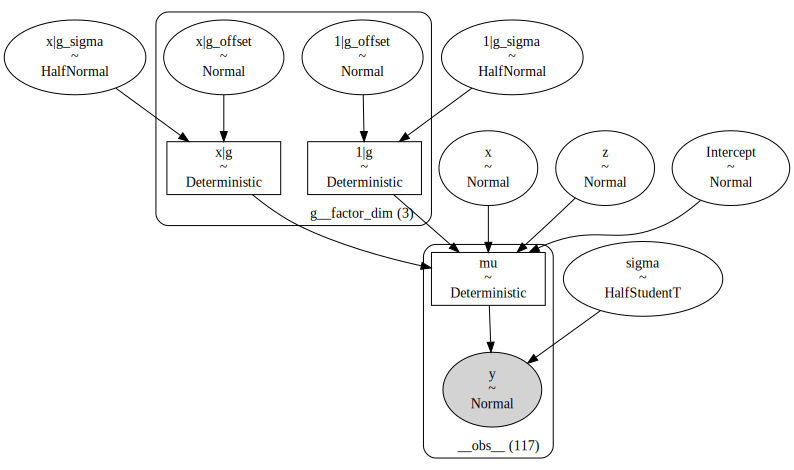

In [9]:
model_h.build()
model_h.graph(name="../fig/bambi_dag")

## Simple linear regression

In [10]:
bikes = pd.read_csv("data/bikes.csv")

In [11]:
model_t = bmb.Model("rented ~ temperature", bikes, family="negativebinomial")
idata_t = model_t.fit(random_seed=123)
model_t

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, temperature]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


       Formula: rented ~ temperature
        Family: negativebinomial
          Link: mu = log
  Observations: 348
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 4.9184)
            temperature ~ Normal(mu: 0.0, sigma: 0.2741)
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

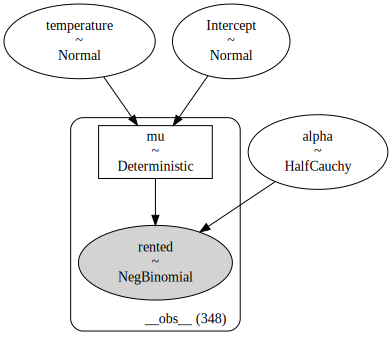

In [12]:
model_t.graph(name="../fig/bambi_linear_bikes_dag")

In [ ]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4)) 
bmb.interpret.plot_predictions(model_t, idata_t, "temperature", ax=axes[0])
bmb.interpret.plot_predictions(model_t, idata_t, "temperature", pps=True, ax=axes[1])
axes[0].plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
axes[1].plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
axes[0].set_title("mean")
axes[1].set_title("predictions");
plt.savefig("../fig/bambi_linear_bikes_mean_pss.png")

In [14]:
model_th = bmb.Model("rented ~ temperature + humidity", bikes, family="negativebinomial")
idata_th = model_th.fit(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rented_alpha, Intercept, temperature, humidity]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


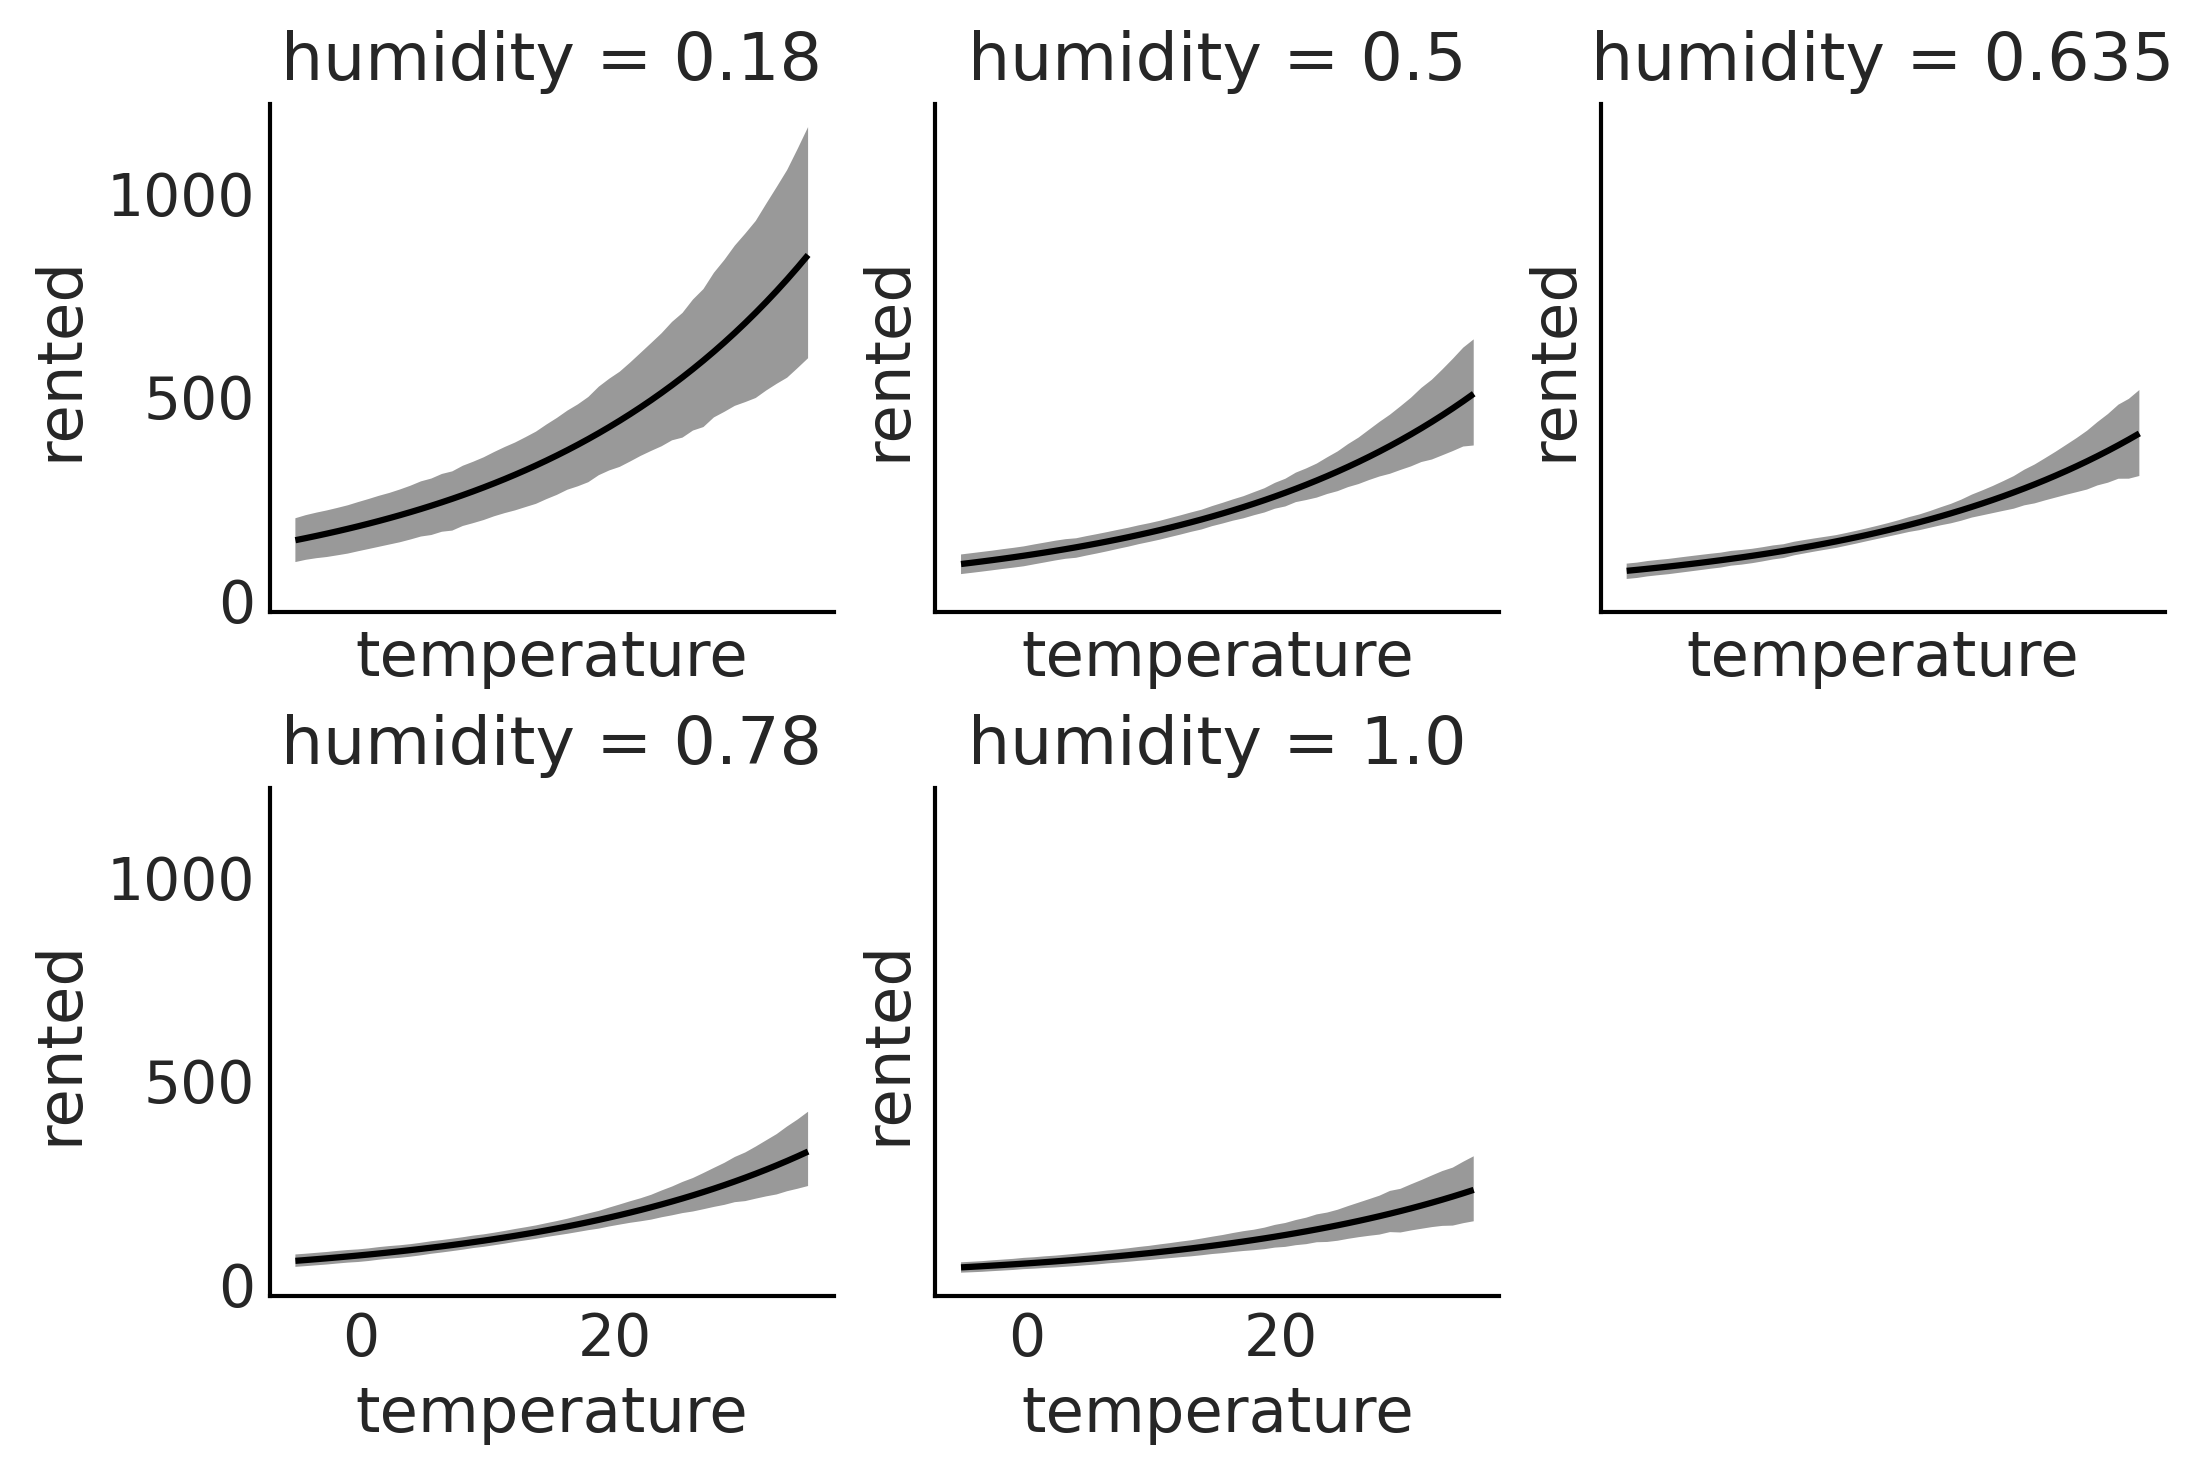

In [15]:
bmb.interpret.plot_predictions(model_th, idata_th, ["temperature", "humidity"],
                               subplot_kwargs={"group":None, "panel":"humidity"},
                               legend=False,
                               fig_kwargs={"sharey":True, "sharex":True});
plt.savefig("../fig/bambi_linear_bikes_th_mean.png")

## Polynomial

In [16]:
model_poly_1 = bmb.Model("rented ~ hour", bikes, family="negativebinomial")
idata_poly_1 = model_poly_1.fit(random_seed=123)
model_poly_4 = bmb.Model("rented ~ poly(hour, degree=4)", bikes, family="negativebinomial")
idata_poly_4 = model_poly_4.fit(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rented_alpha, Intercept, hour]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rented_alpha, Intercept, poly(hour, degree=4)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


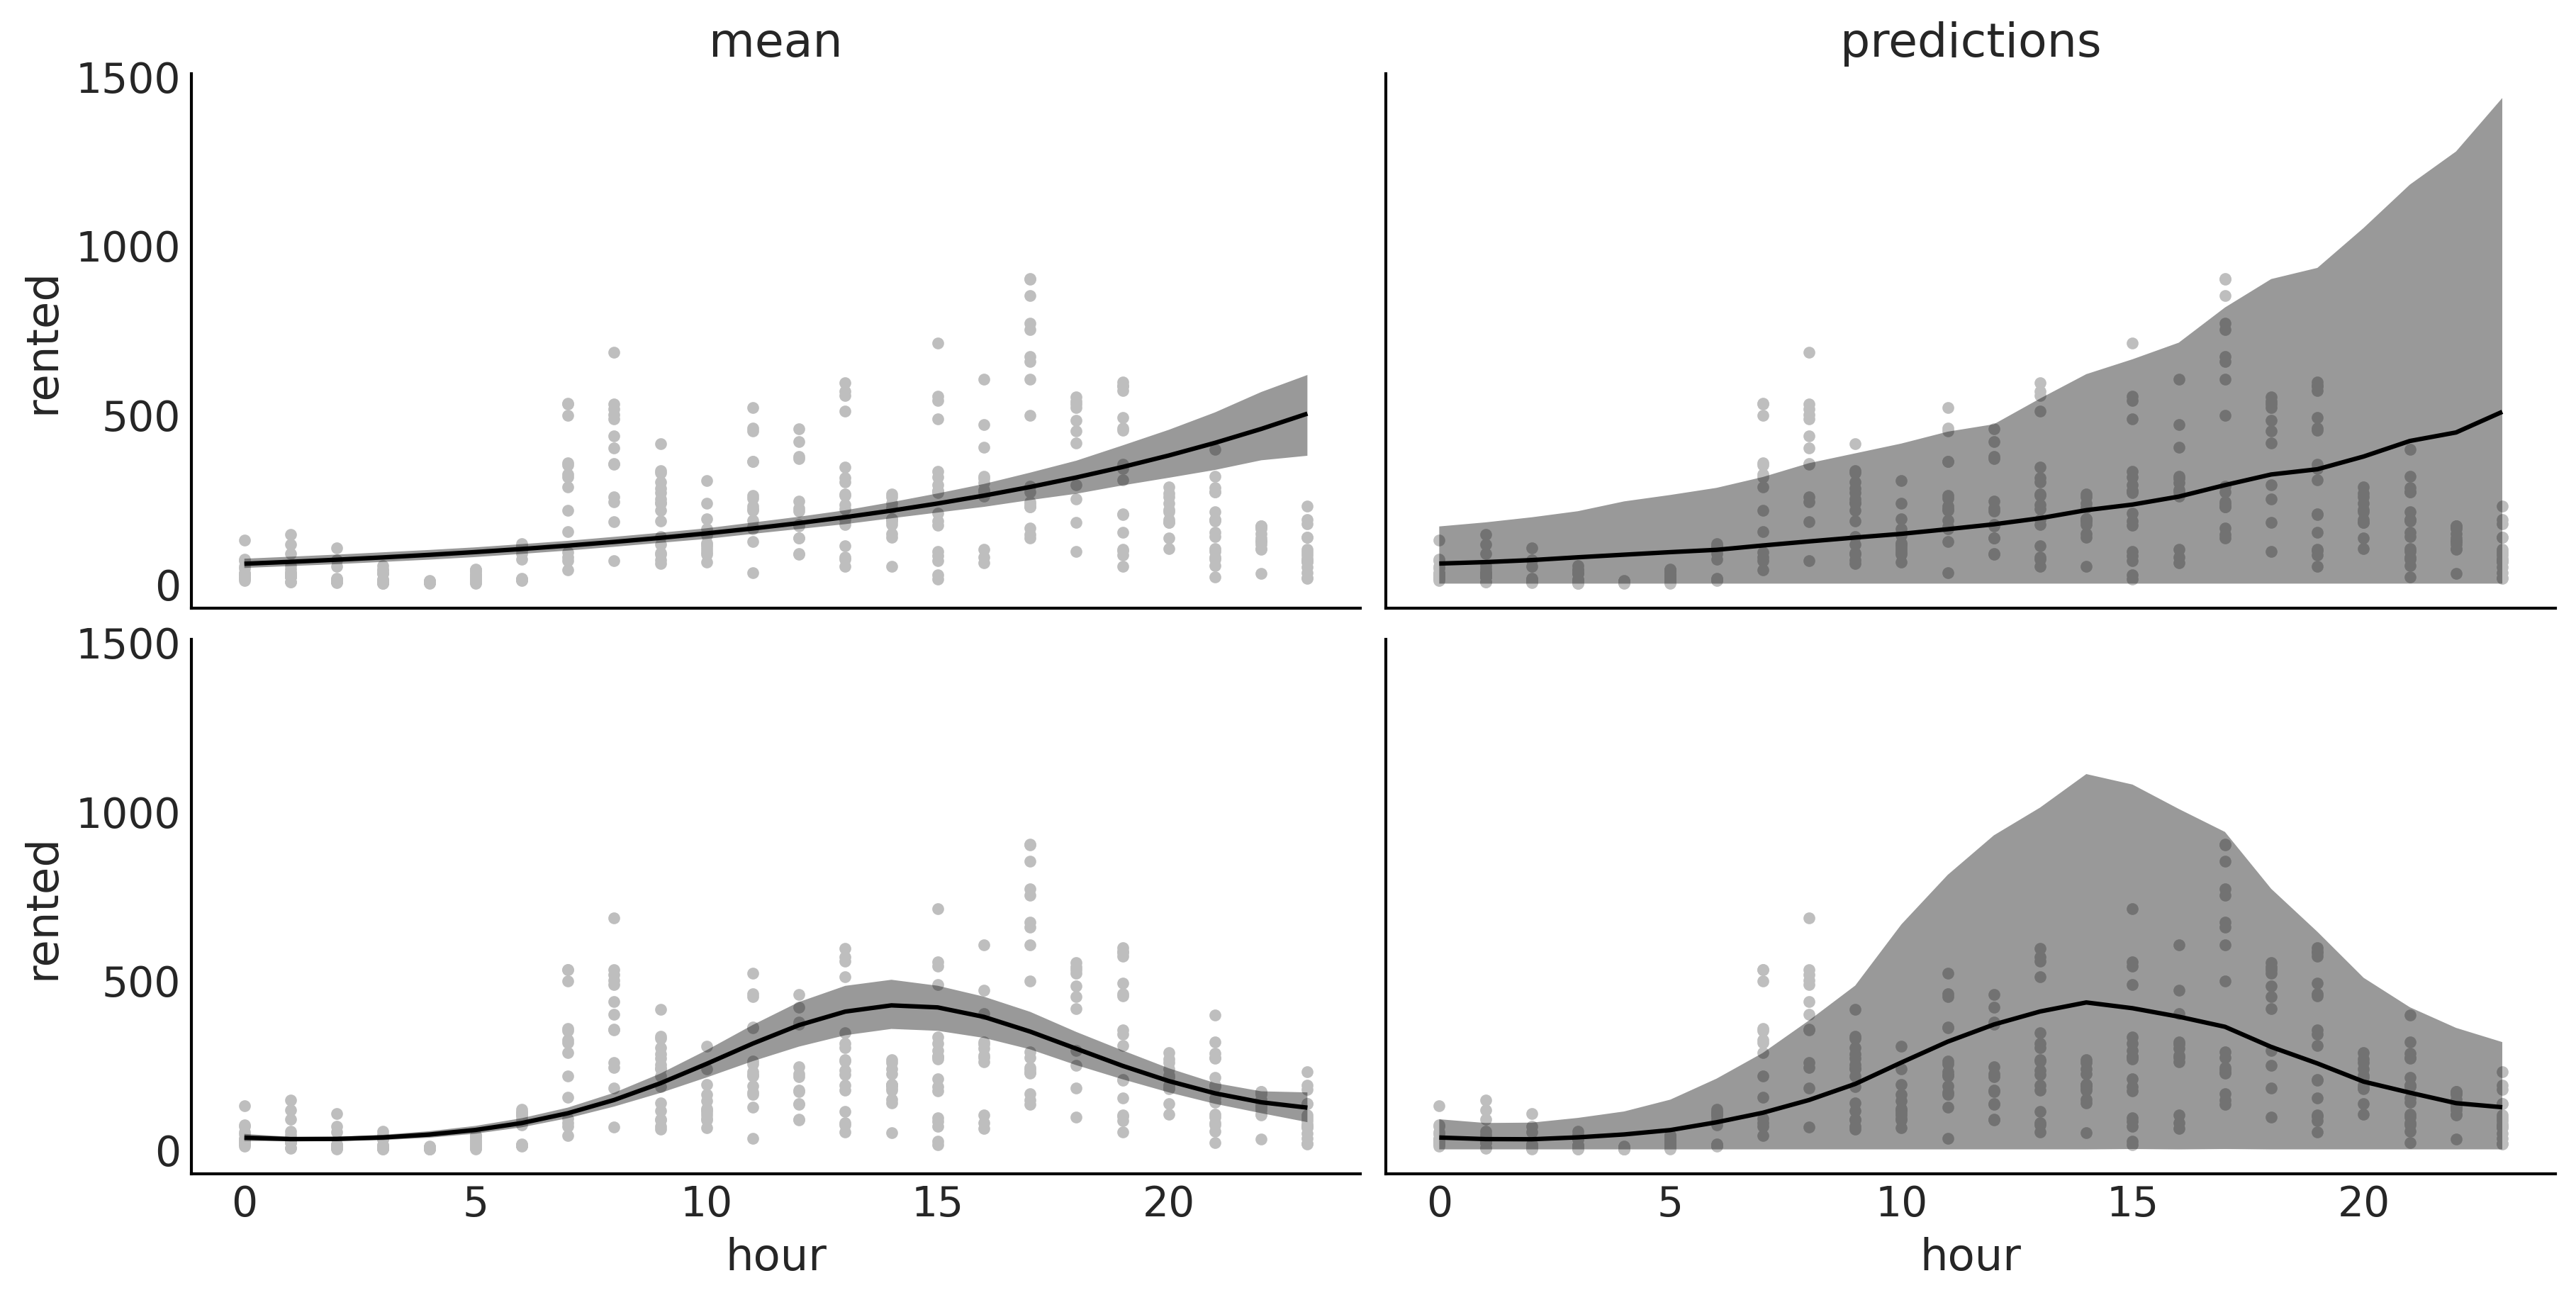

In [17]:
_, axes = plt.subplots(2, 2, sharey=True, sharex="col", figsize=(12, 6)) 
bmb.interpret.plot_predictions(model_poly_1, idata_poly_1, "hour", ax=axes[0, 0])
bmb.interpret.plot_predictions(model_poly_1, idata_poly_1, "hour", pps=True, ax=axes[0, 1])
bmb.interpret.plot_predictions(model_poly_4, idata_poly_4, "hour", ax=axes[1, 0])
bmb.interpret.plot_predictions(model_poly_4, idata_poly_4, "hour", pps=True, ax=axes[1, 1])

for ax in axes.ravel():
    ax.plot(bikes.hour, bikes.rented, "C2.", zorder=-3)
axes[0, 0].set_title("mean")
axes[0, 1].set_title("predictions")
axes[0, 0].set_xlabel("")
axes[0, 1].set_xlabel("")
axes[0, 1].set_ylabel("")
axes[1, 1].set_ylabel("")

plt.savefig("../fig/bambi_poly_bikes_mean_pss.png")

## Splines

In [18]:
num_knots = 6
knots = np.linspace(0, 23, num_knots+2)[1:-1]
model_spline = bmb.Model("rented ~ bs(hour, degree=3, knots=knots)", bikes, family="negativebinomial")
idata_spline = model_spline.fit(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rented_alpha, Intercept, bs(hour, degree=3, knots=knots)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


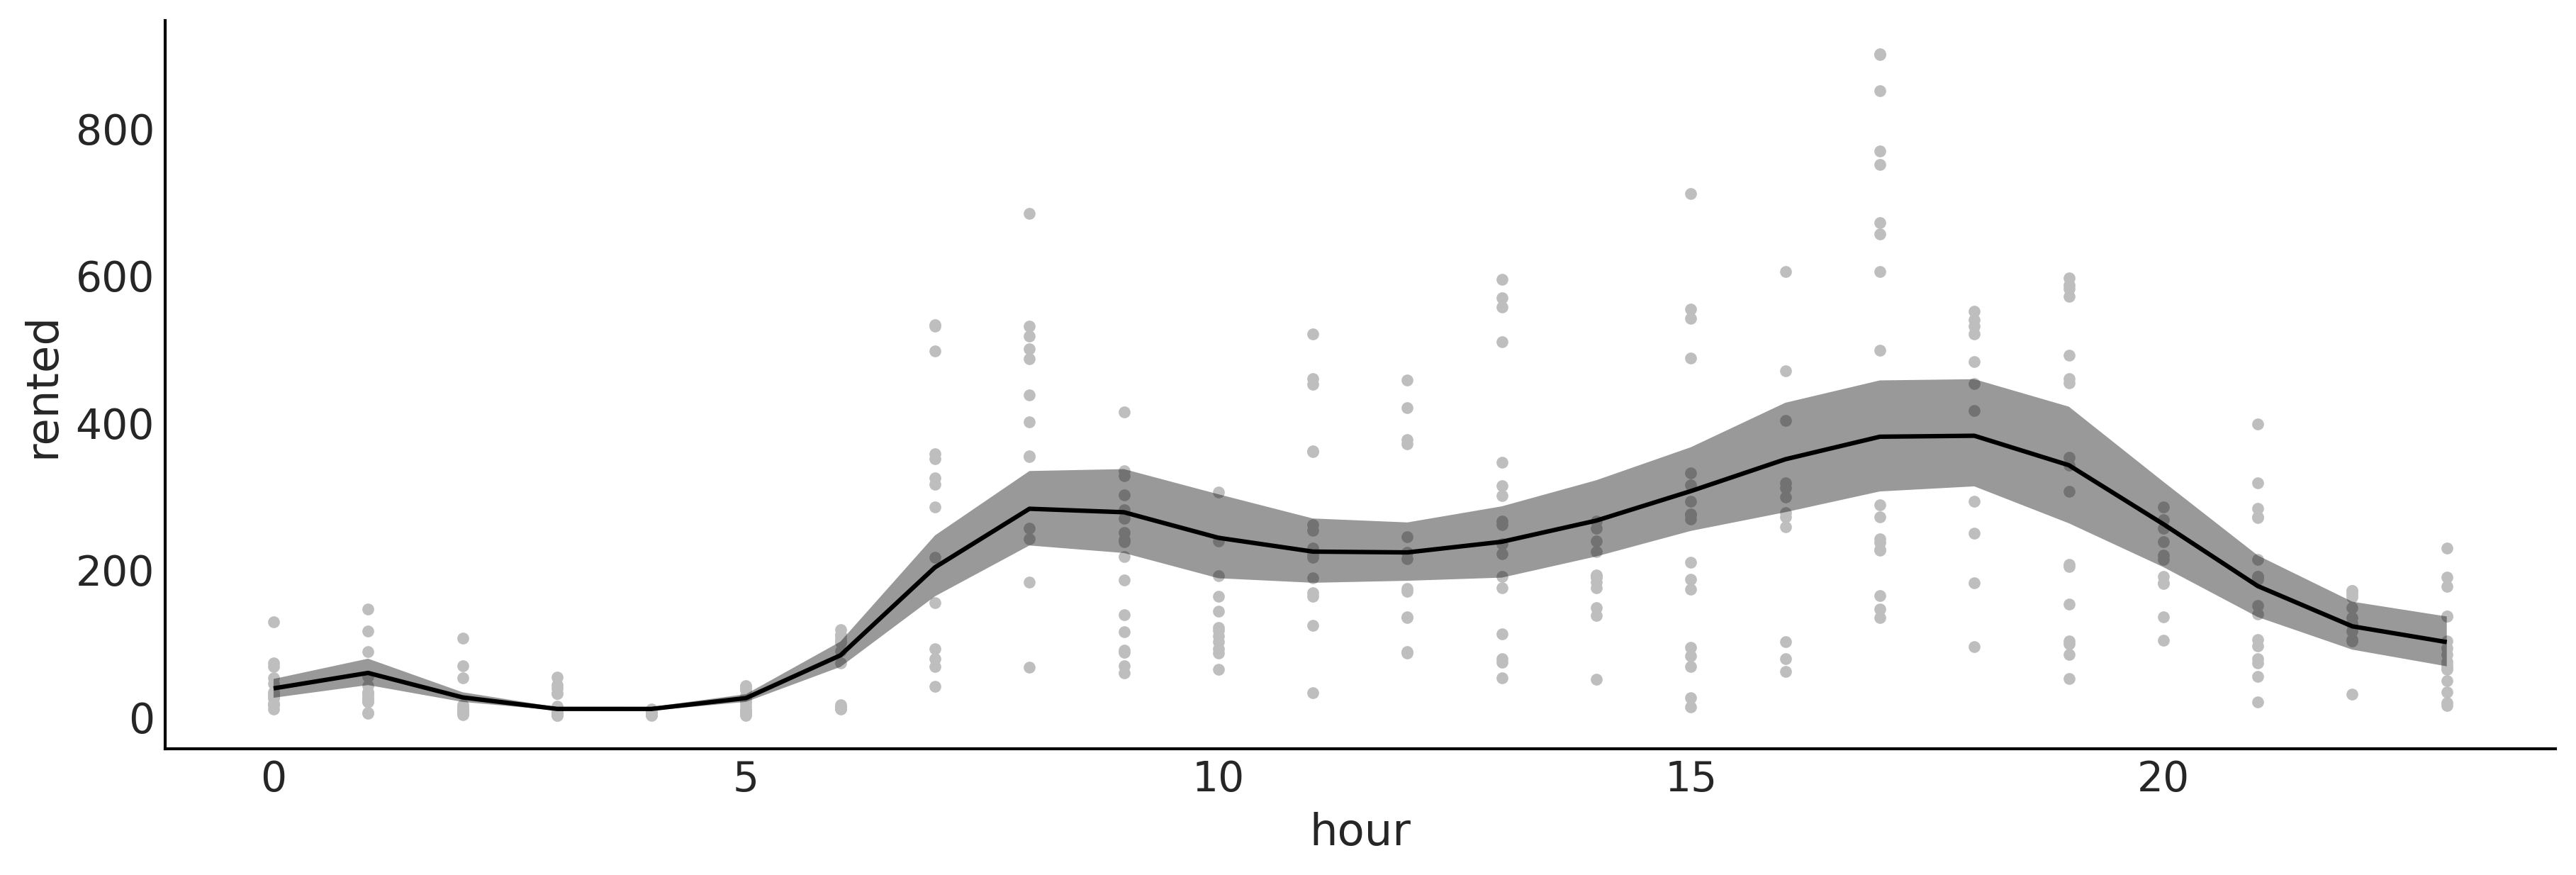

In [19]:
_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 4)) 
bmb.interpret.plot_predictions(model_spline, idata_spline, "hour", ax=ax)
ax.plot(bikes.hour, bikes.rented, "C2.", zorder=-3)
plt.savefig("../fig/bambi_spline_bikes.png");

## Distributional models

In [20]:
babies = pd.read_csv("data/babies.csv")

In [21]:

formula = bmb.Formula(
    "length ~ np.sqrt(month)",
    "sigma ~ month"
)
model_dis = bmb.Model(formula, babies)
idata_dis = model_dis.fit(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, np.sqrt(month), sigma_Intercept, sigma_month]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [22]:
model_cons = bmb.Model("length ~ np.sqrt(month)", babies)
idata_cons = model_cons.fit(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [length_sigma, Intercept, np.sqrt(month)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


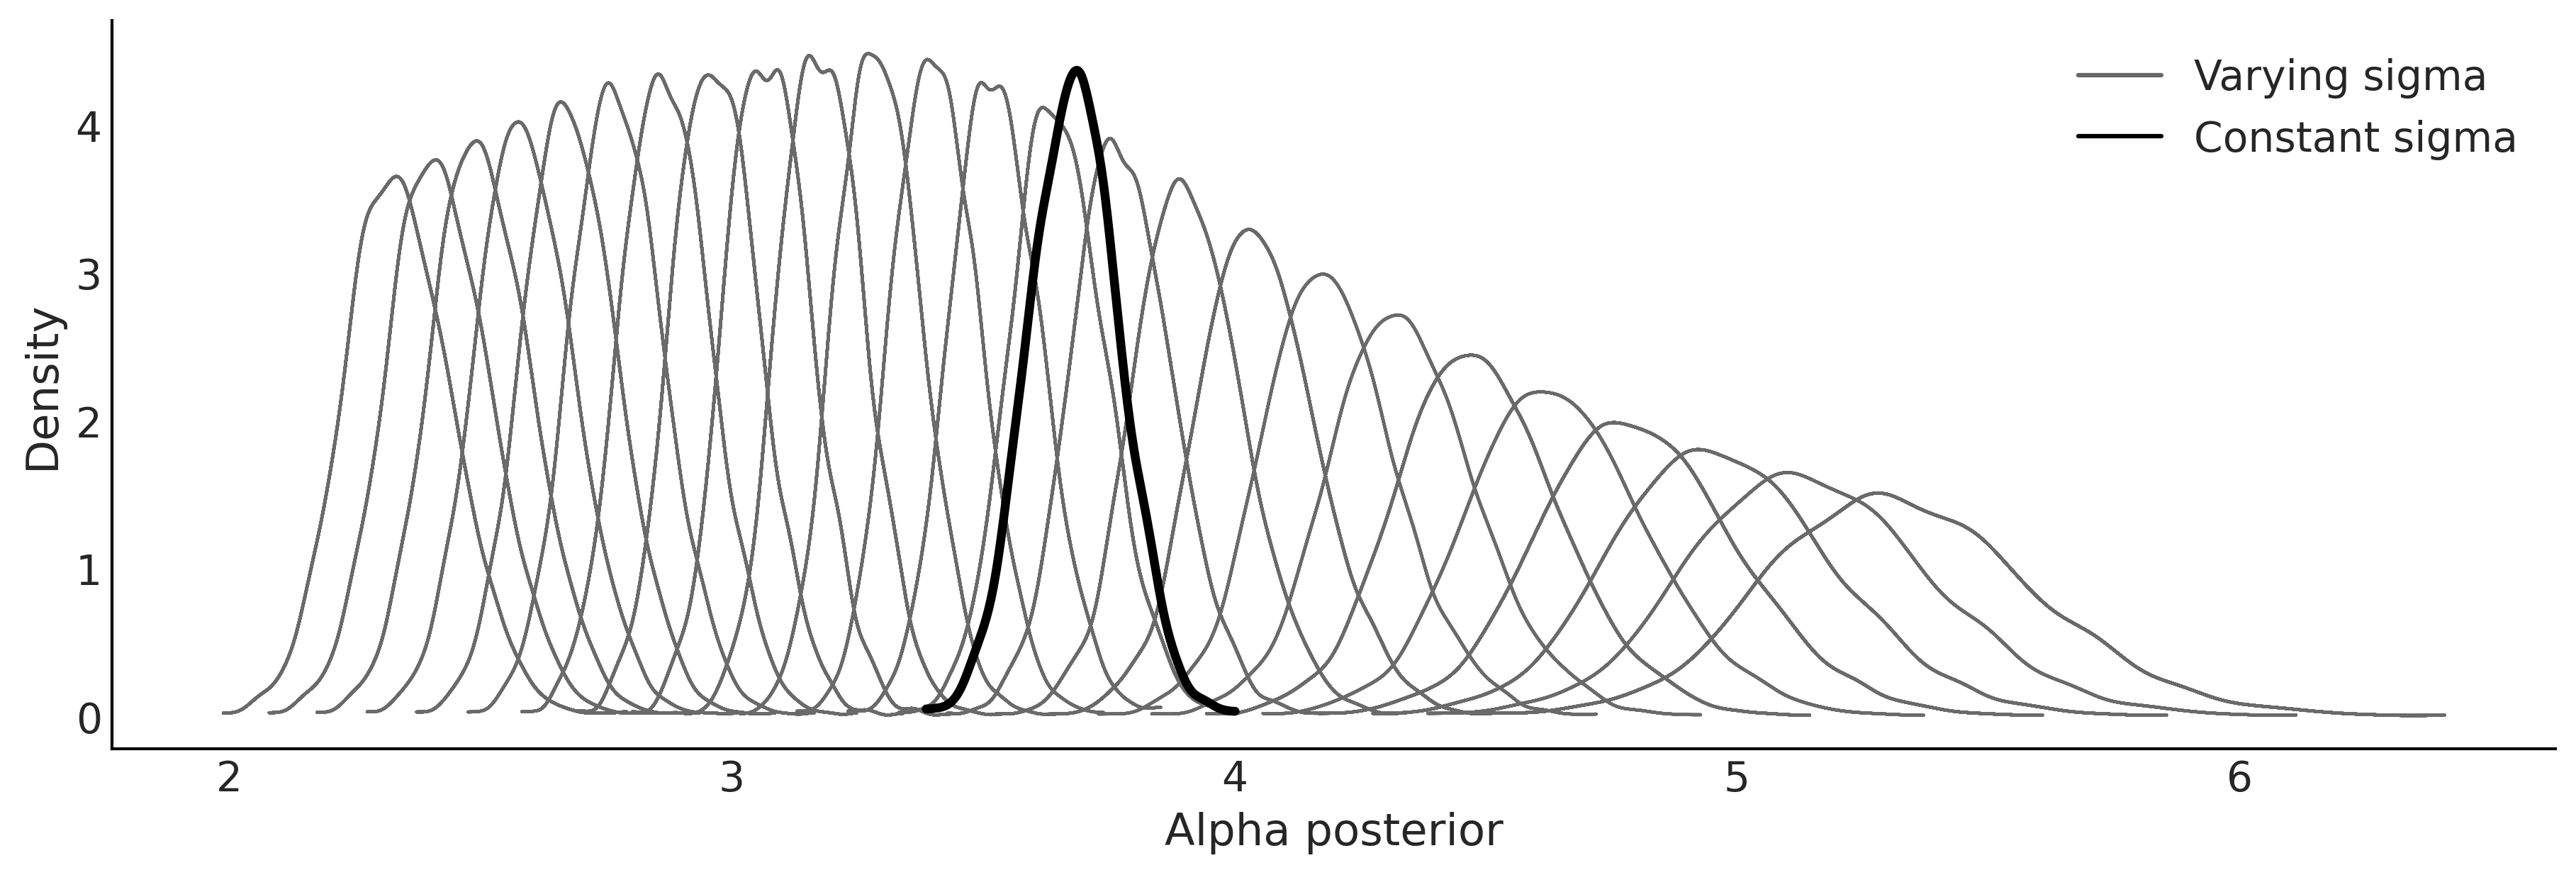

In [23]:
fig, ax = plt.subplots(figsize=(12, 4))
from matplotlib.lines import Line2D

for idx in idata_dis.posterior.coords.get("length_obs"):
    values = idata_dis.posterior["sigma"].sel(length_obs=idx).to_numpy().flatten()
    grid, pdf = az.kde(values)
    ax.plot(grid, pdf, lw=1, color="C1")

values = idata_cons.posterior["length_sigma"].to_numpy().flatten()
grid, pdf = az.kde(values)
ax.plot(grid, pdf, lw=3, color="C0");

# Create legend
handles = [
    Line2D([0], [0], label="Varying sigma", lw=1.5, color="k", alpha=0.6),
    Line2D([0], [0], label="Constant sigma", lw=1.5, color="C0")
]

legend = ax.legend(handles=handles, loc="upper right", fontsize=14)

ax.set(xlabel="Alpha posterior", ylabel="Density")
plt.savefig("../fig/babies_bambi_varying.png")

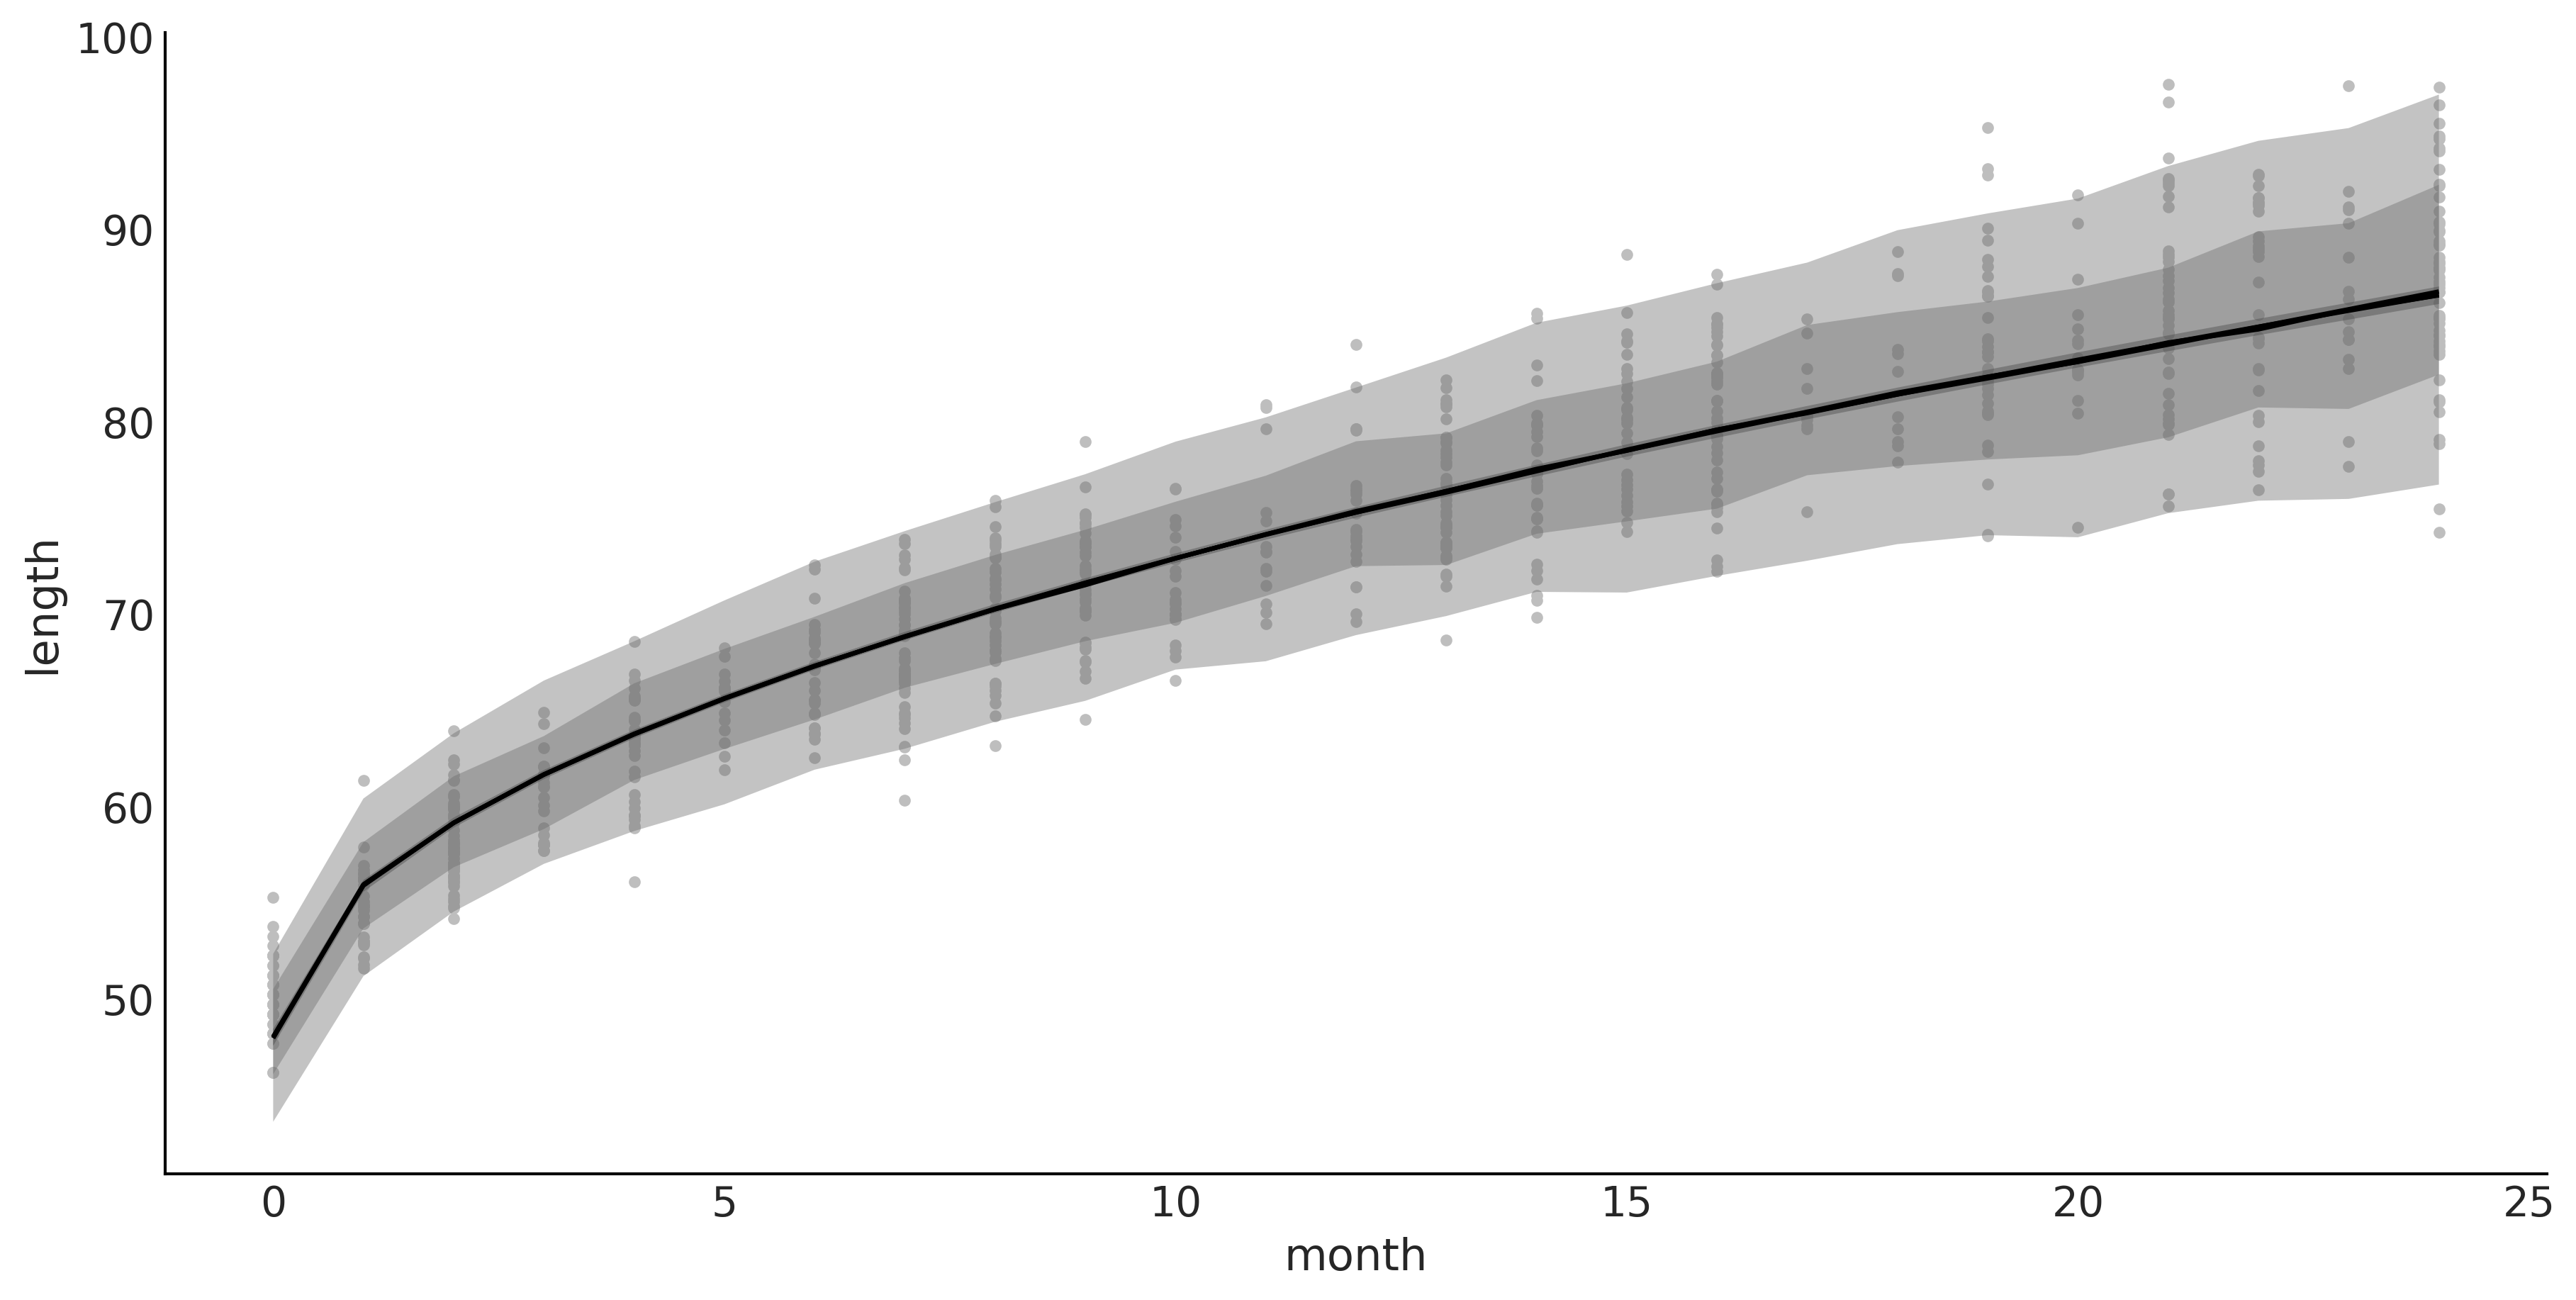

In [24]:
_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6)) 
bmb.interpret.plot_predictions(model_dis, idata_dis, "month", ax=ax, fig_kwargs={"color":"k"})
bmb.interpret.plot_predictions(model_dis, idata_dis, "month", pps=True, ax=ax)
ax_ = bmb.interpret.plot_predictions(model_dis, idata_dis, "month", pps=True, ax=ax, prob=0.65)
ax_[1][0].get_children()[5].set_facecolor('C1')  

ax.plot(babies.month, babies.length, "C2.", zorder=-3)
plt.savefig("../fig/babies_bambi_fit.png");

In [25]:
model_dis.predict(idata_dis, kind="pps", data=pd.DataFrame({"month":[0.5]}))

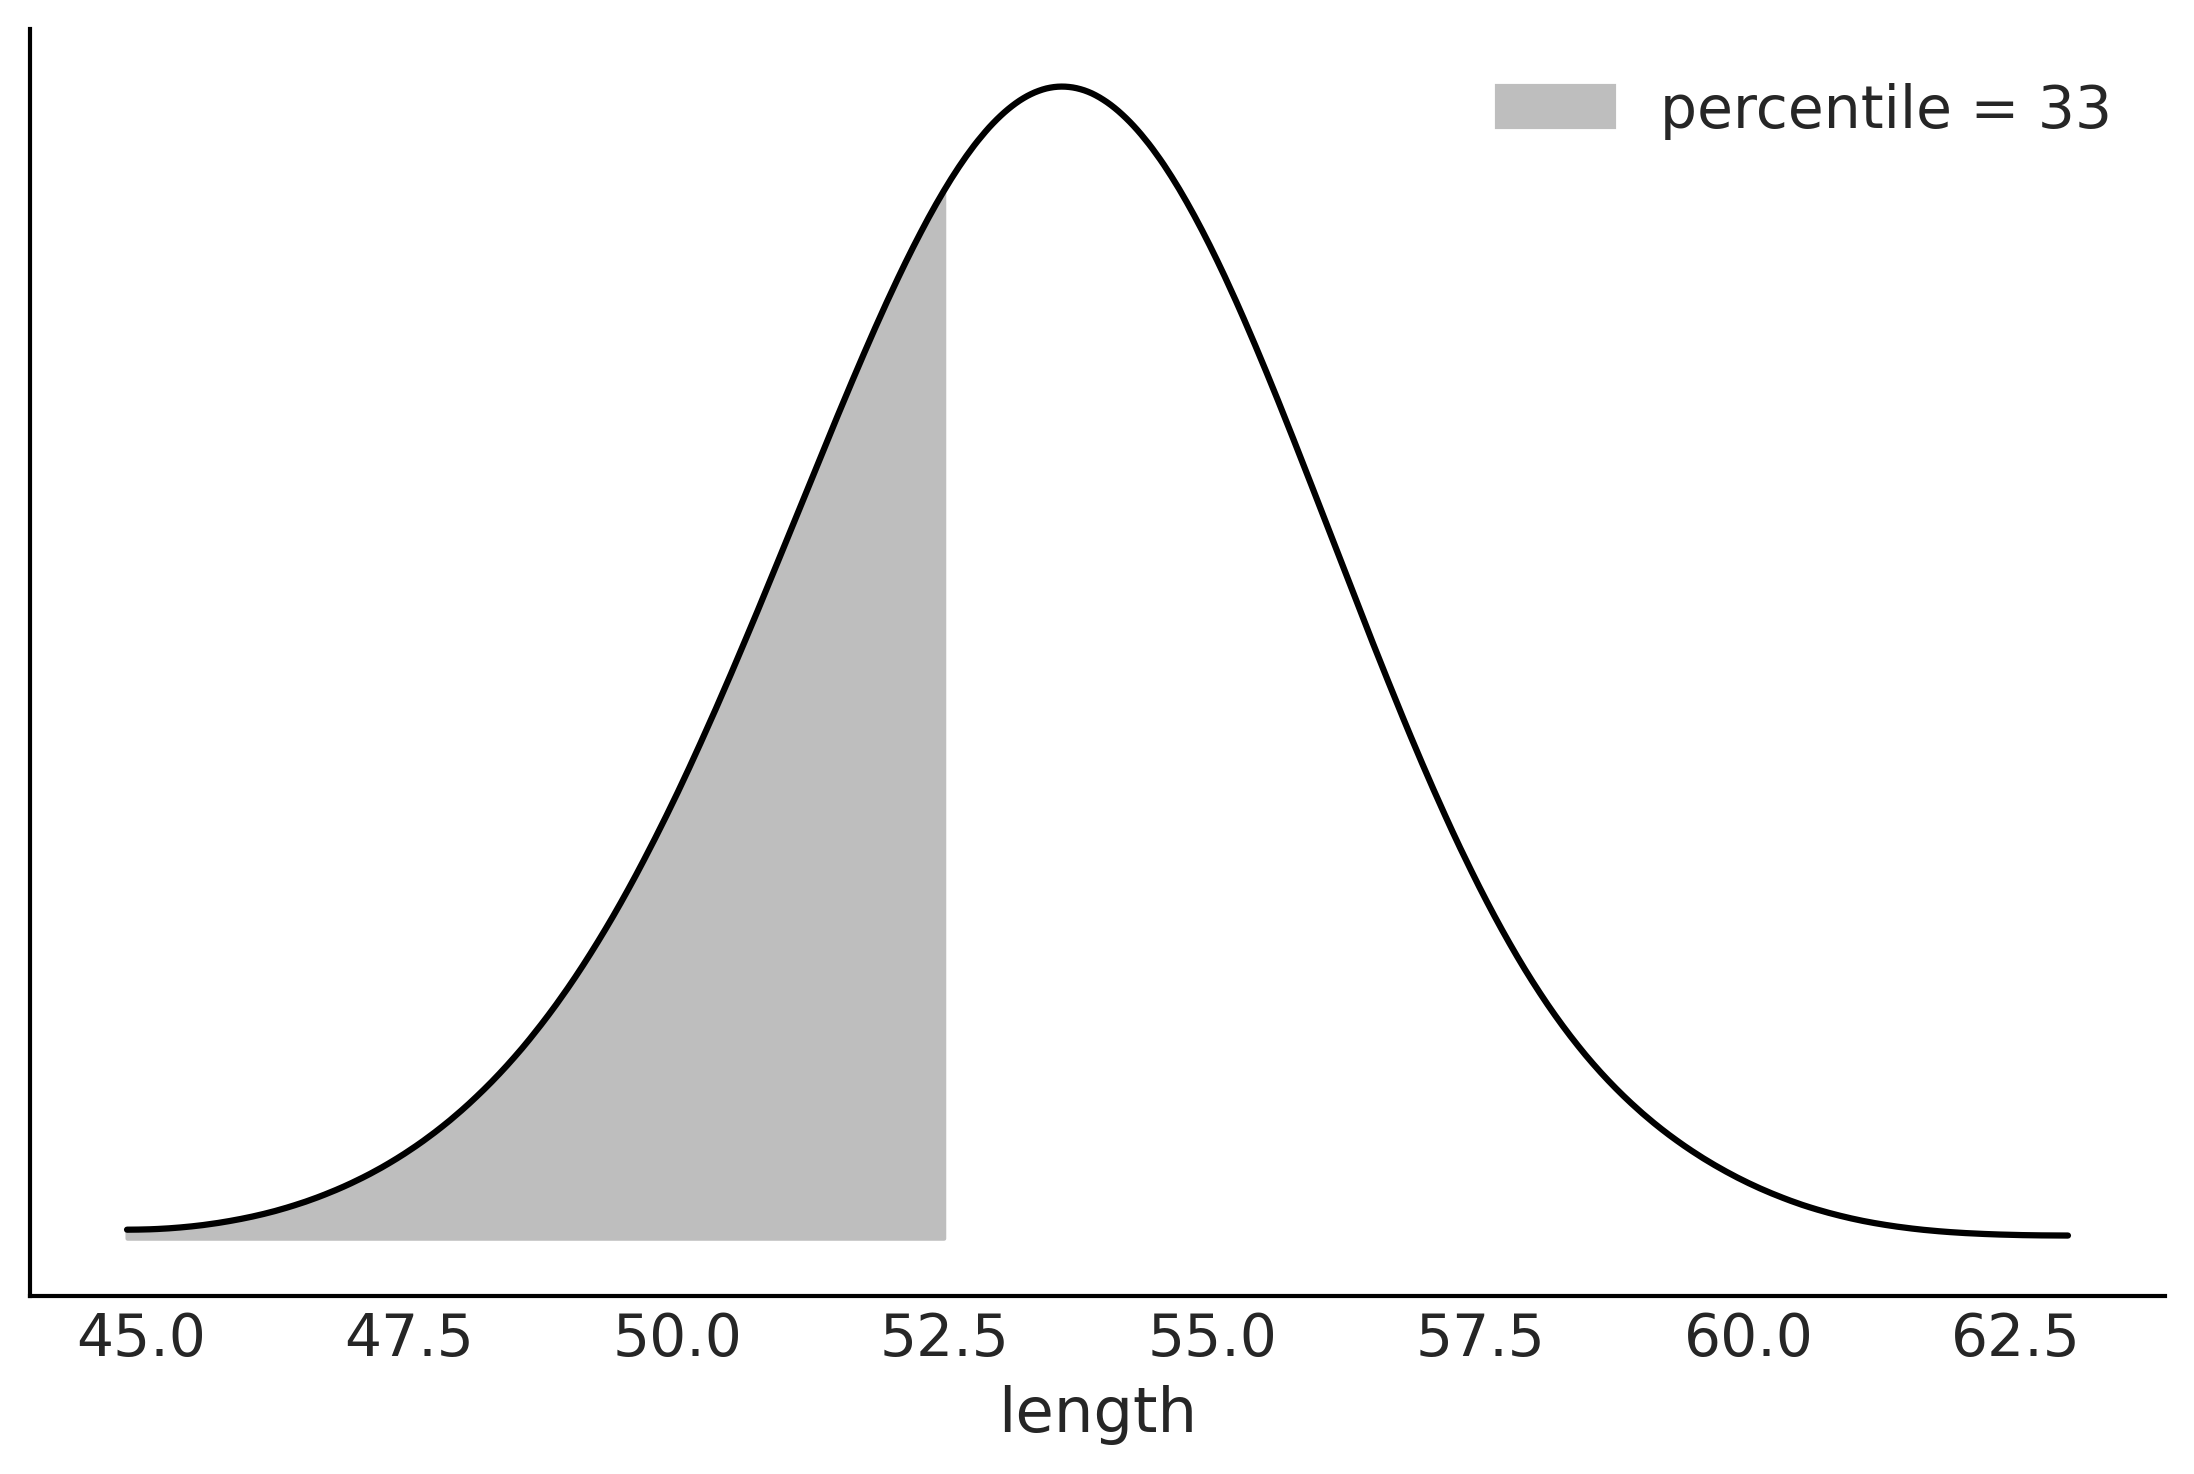

In [26]:
ref = 52.5
y_ppc = idata_dis.posterior_predictive["length"].stack(sample=("chain", "draw"))
grid, pdf = az.stats.density_utils._kde_linear(y_ppc.values)
plt.plot(grid, pdf)
percentile = int((y_ppc <= ref).mean() * 100)
plt.fill_between(
    grid[grid < ref],
    pdf[grid < ref],
    label="percentile = {:2d}".format(percentile),
    color="C2",
)
plt.xlabel("length")
plt.yticks([])
plt.legend()
plt.savefig("../fig/babies_ppc_bambi.png")

## Categorical Predictors

In [27]:
penguins = pd.read_csv("data/penguins.csv").dropna()
penguins.head()

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.75,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.80,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.25,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.45,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.65,male,2007


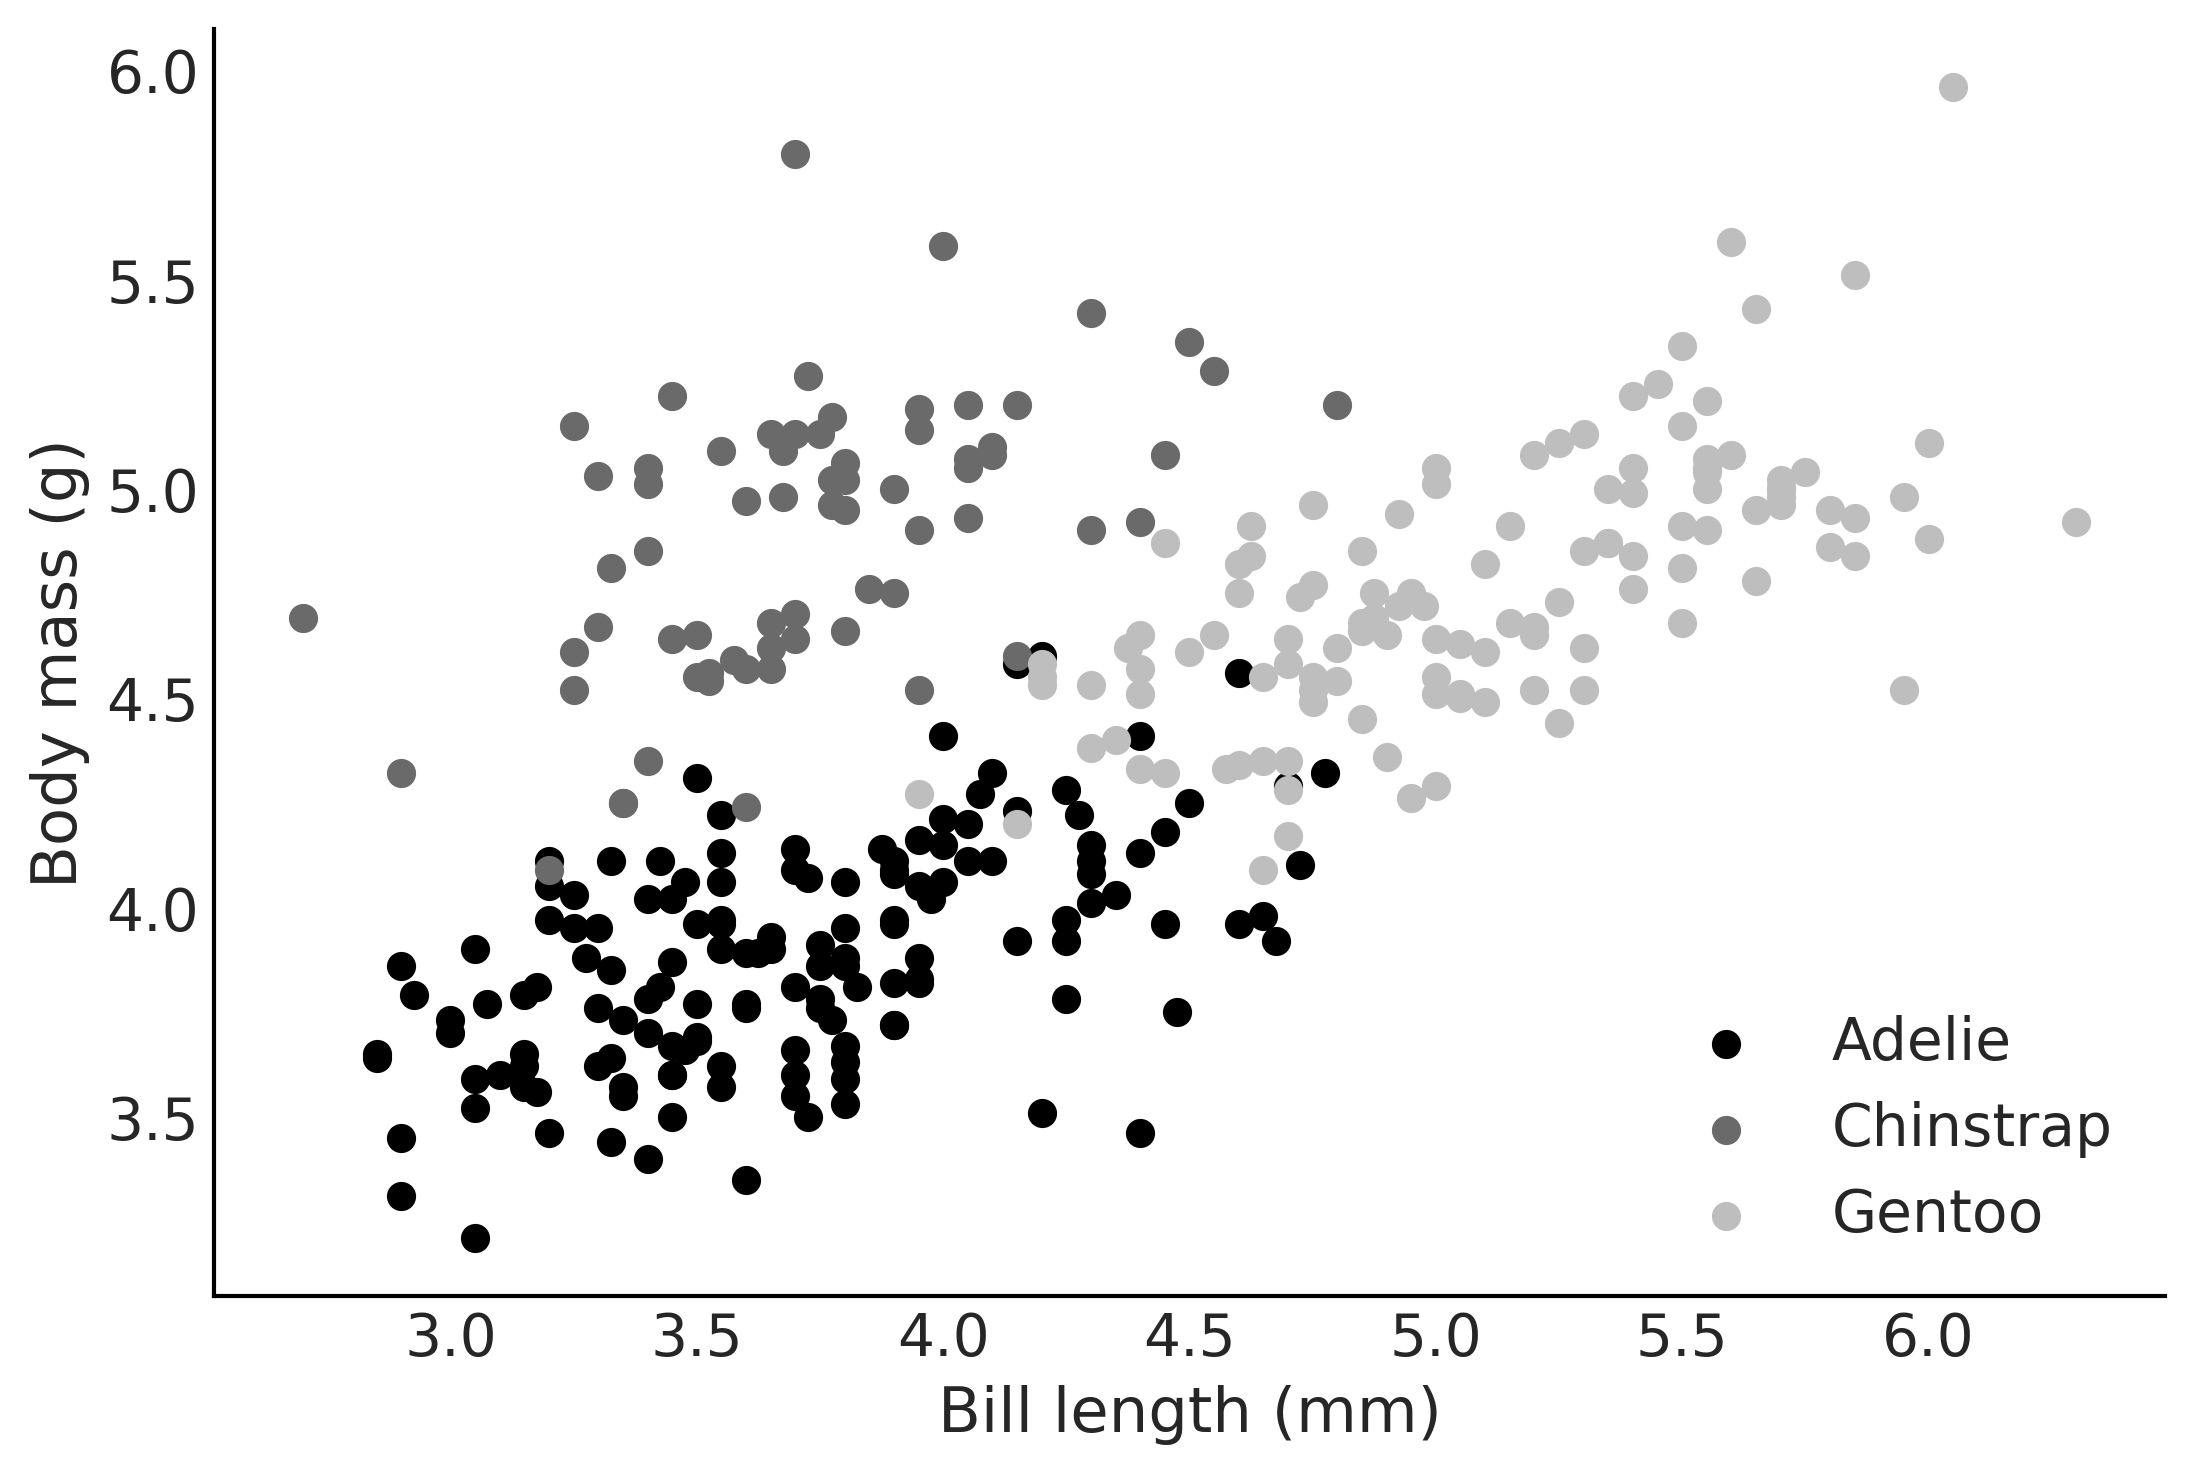

In [28]:
# Get unique categories
unique_categories = np.unique(penguins.species)

# Create color map for categories
category_color_map = {cat: f"C{i}" for i, cat in enumerate(unique_categories)}

# Generate colors for each category
colors = [category_color_map[cat] for cat in penguins.species]

# Create scatter plot for each category
for cat in unique_categories:
    category_data = penguins[penguins.species == cat]
    plt.scatter(category_data.body_mass, category_data.bill_length, c=category_color_map[cat], label=cat)

# Add labels and legend
plt.ylabel("Body mass (g)")
plt.xlabel("Bill length (mm)")
plt.legend(labels=unique_categories, loc="lower right")
plt.savefig("../fig/penguins_scatter.png")

In [29]:
model_p = bmb.Model("body_mass ~ bill_length + species", data=penguins)
idata_p = model_p.fit(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [body_mass_sigma, Intercept, bill_length, species]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


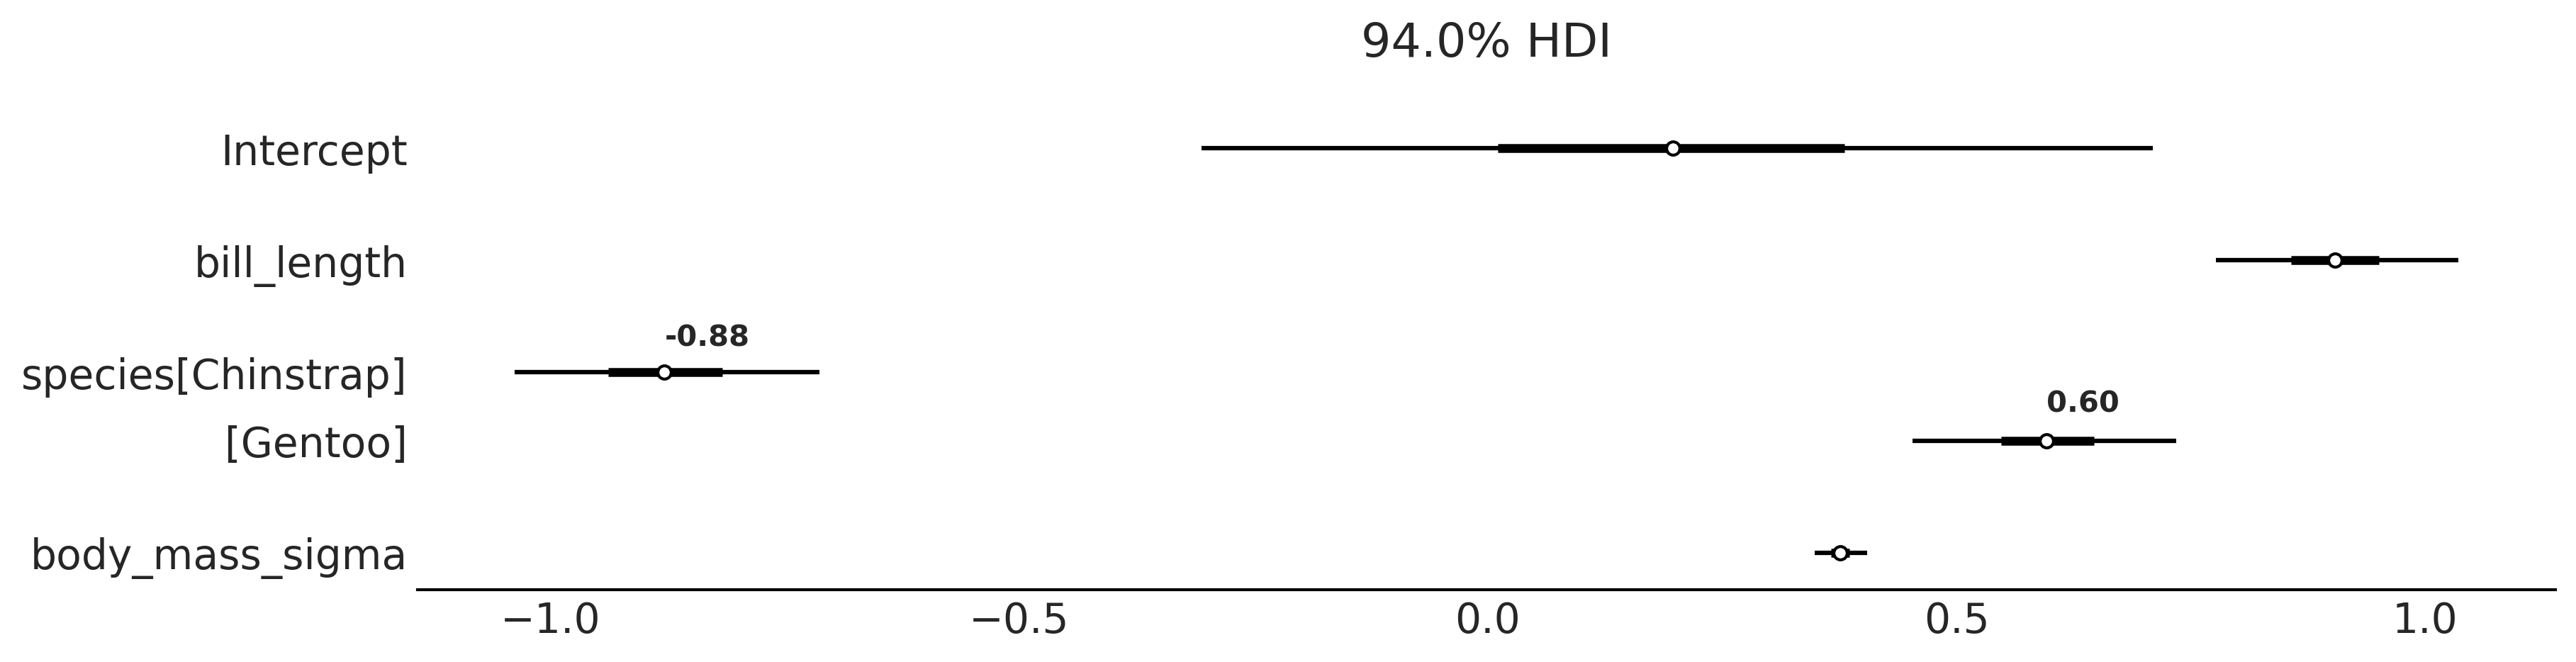

In [30]:
ax = az.plot_forest(idata_p, combined=True, figsize=(12, 3));
mean_chinstrap = idata_p.posterior["species"].sel(species_dim="Chinstrap").mean()
mean_gentoo = idata_p.posterior["species"].sel(species_dim="Gentoo").mean()
ax[0].annotate(f"{mean_chinstrap.item():.2f}", (mean_chinstrap , 2.5), weight='bold')
ax[0].annotate(f"{mean_gentoo.item():.2f}", (mean_gentoo , 1.7), weight='bold')
plt.savefig("../fig/penguins_posterior.png")

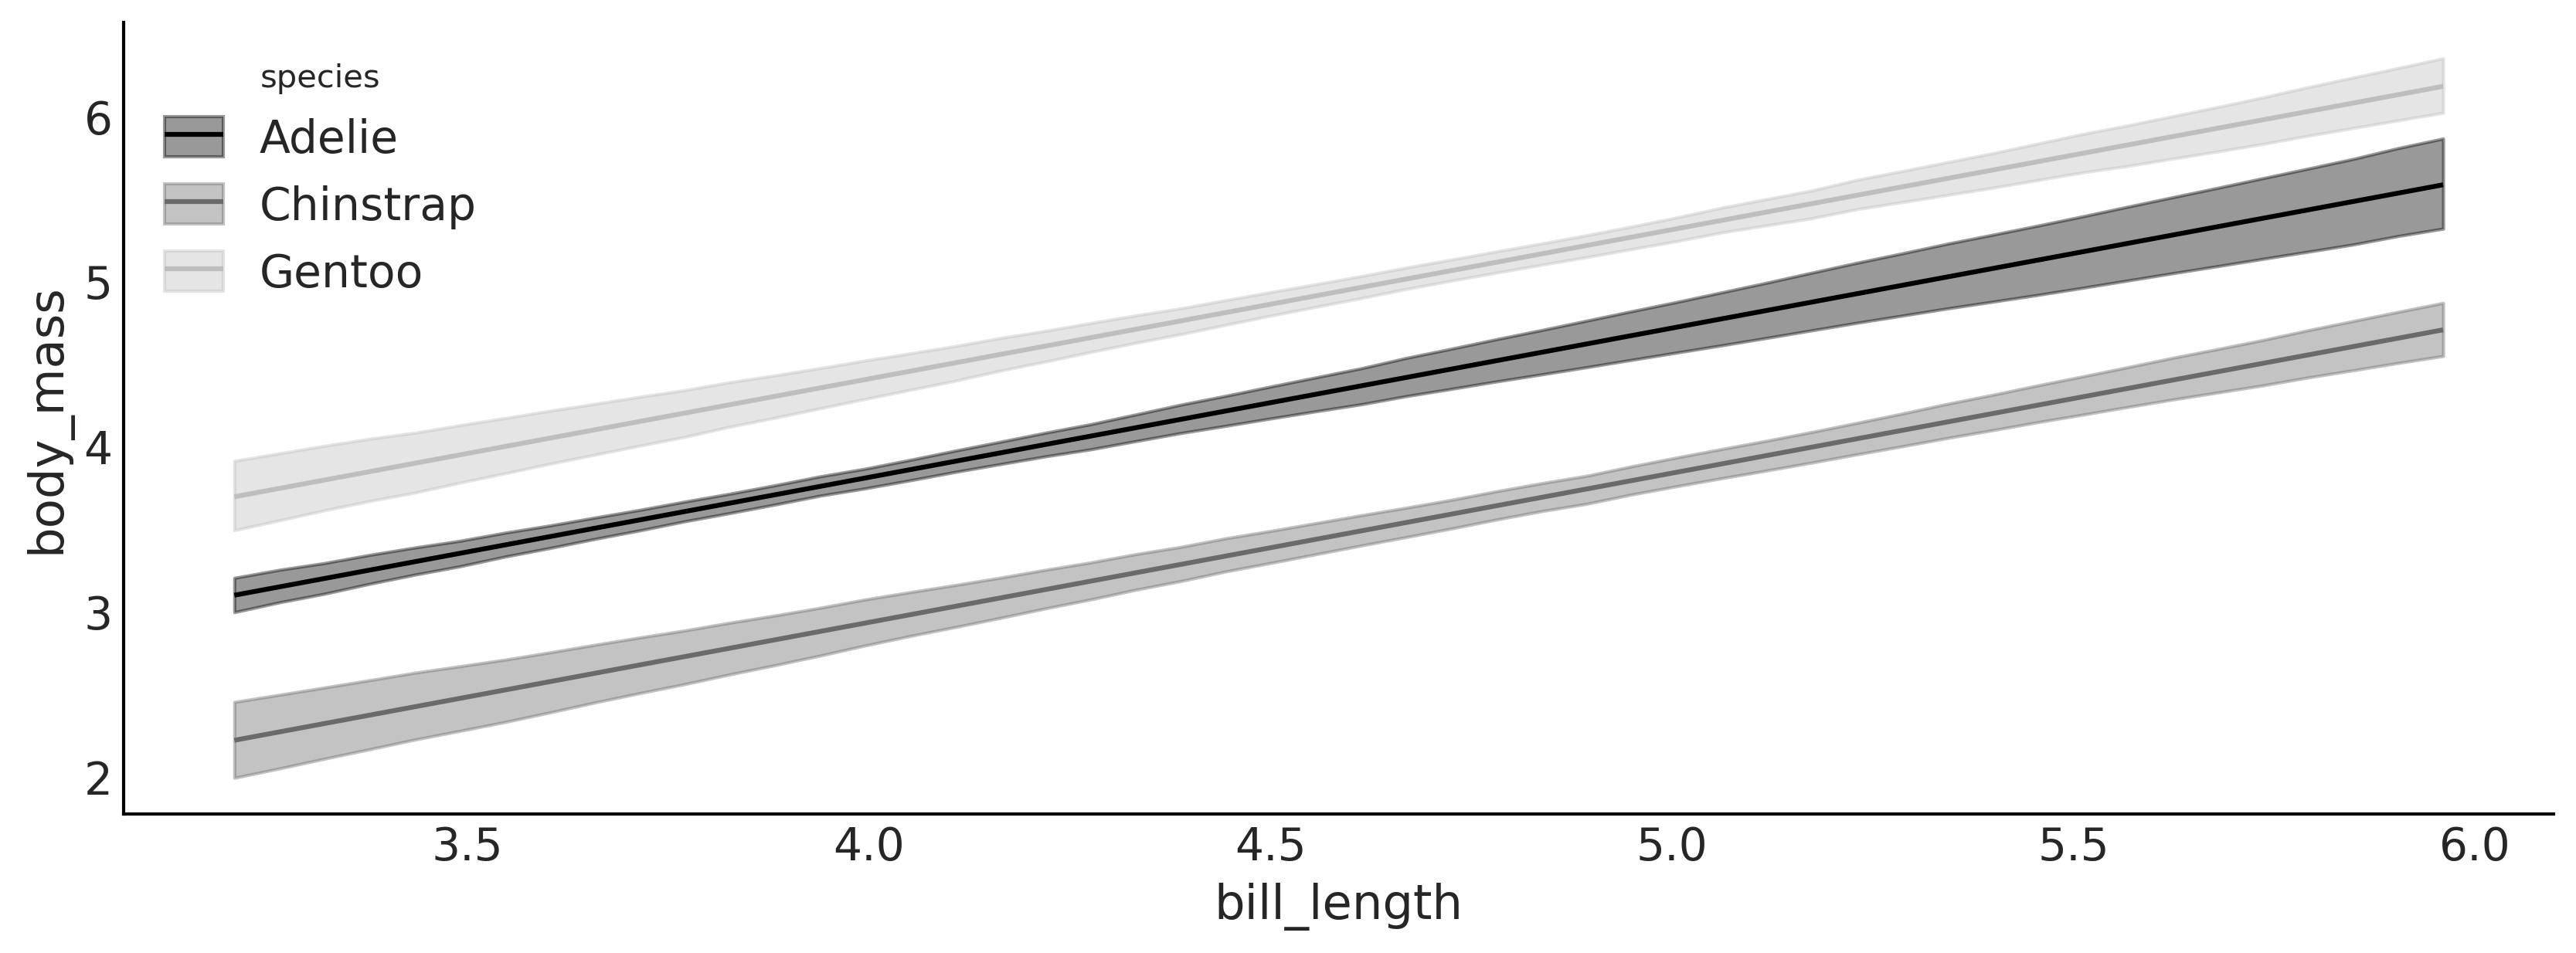

In [31]:
bmb.interpret.plot_predictions(model_p, idata_p, ["bill_length",  "species"], fig_kwargs={"figsize":(11, 4)})
plt.savefig("../fig/penguins_predictions.png")

## Interactions

In [32]:
model_int = bmb.Model("body_mass ~ bill_depth + bill_length + bill_depth:bill_length", data=penguins)
idata_int = model_int.fit(random_seed=123)


model_noint = bmb.Model("body_mass ~ bill_depth + bill_length", data=penguins)
idata_noint = model_noint.fit(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [body_mass_sigma, Intercept, bill_depth, bill_length, bill_depth:bill_length]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [body_mass_sigma, Intercept, bill_depth, bill_length]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


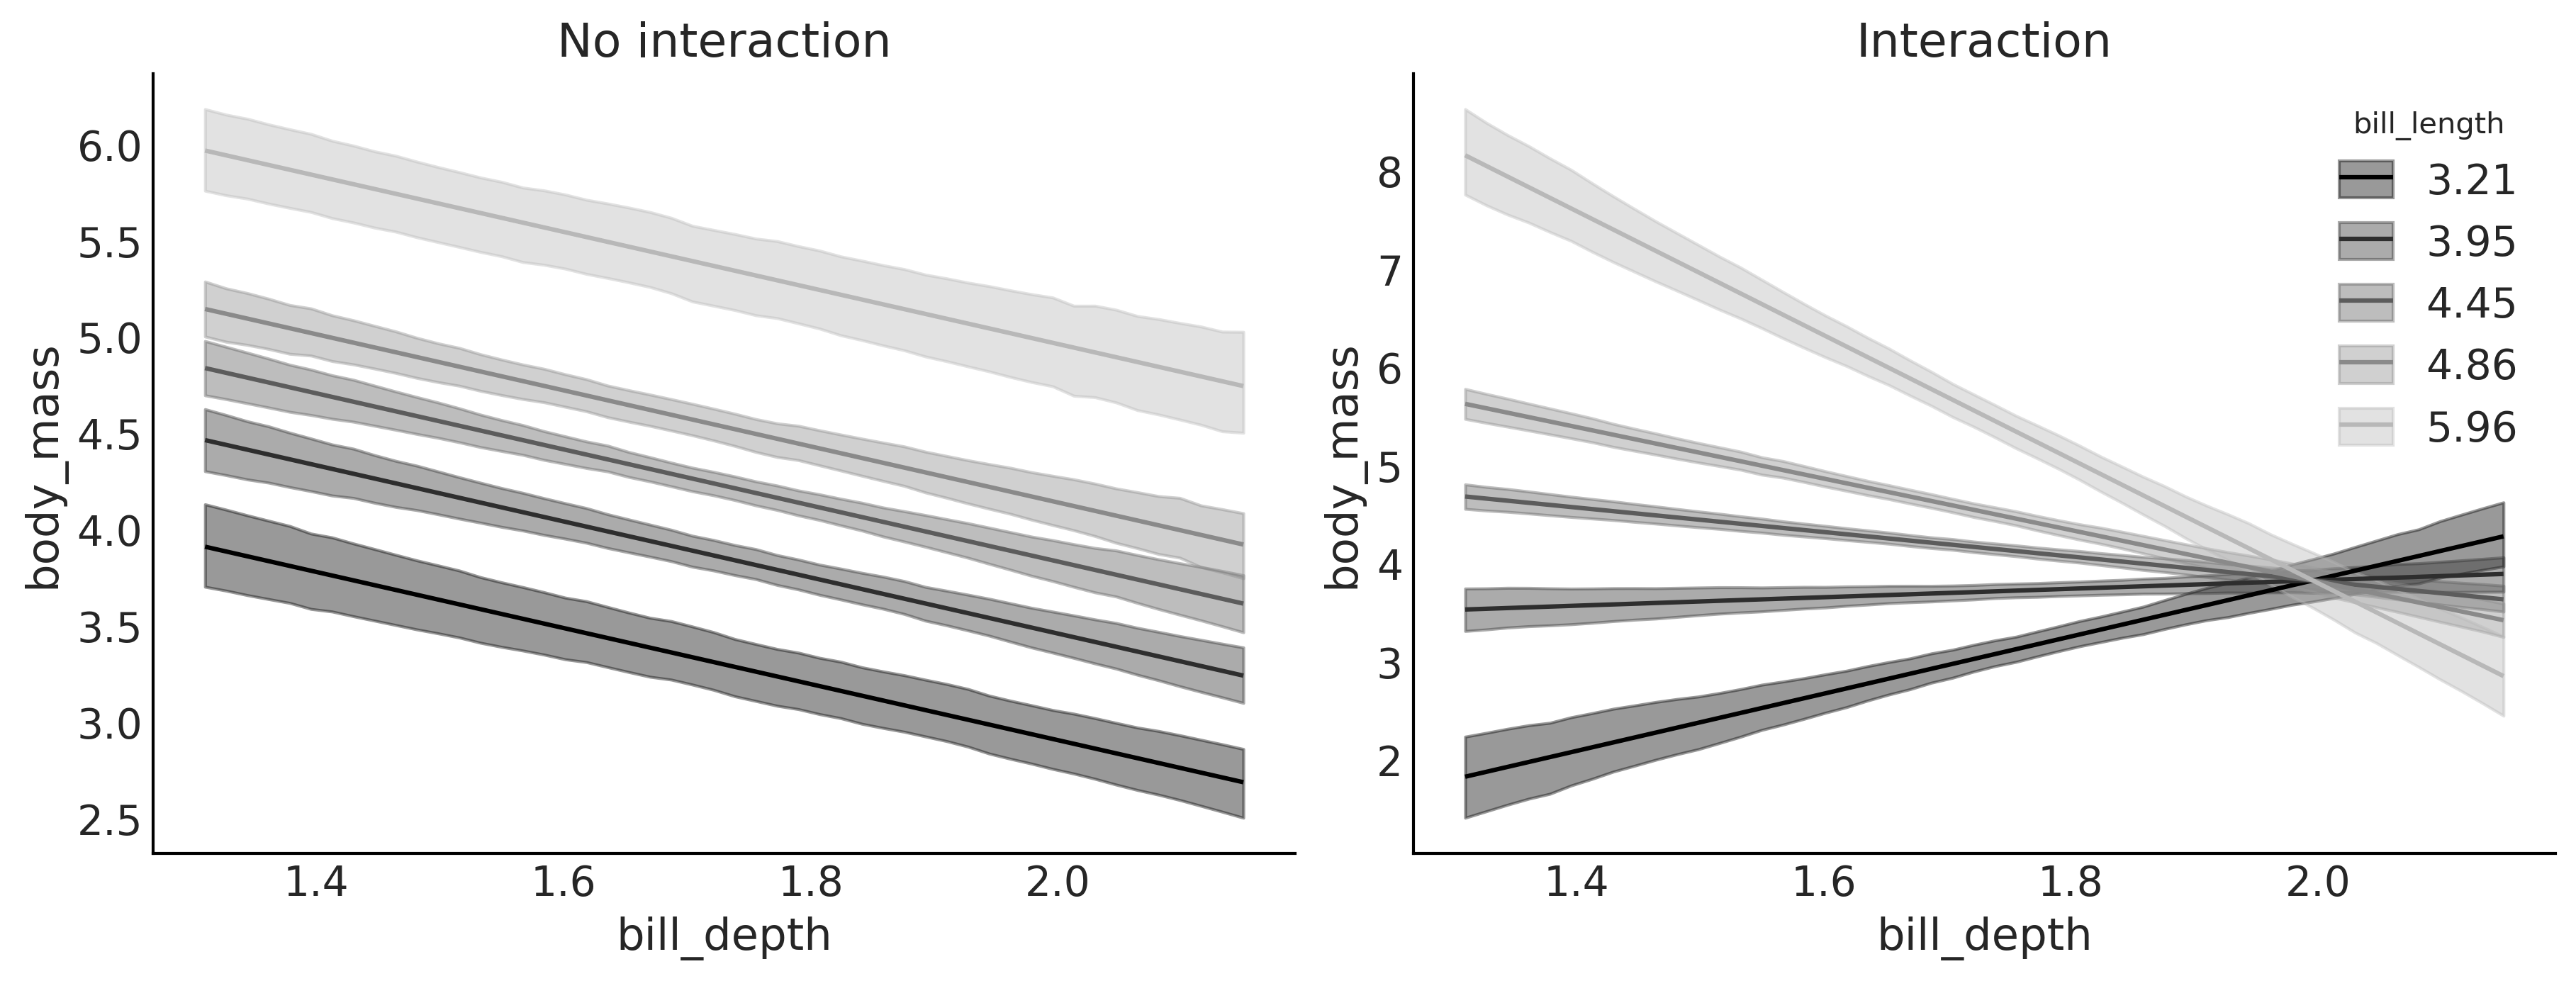

In [33]:
plt.rc("axes", prop_cycle=gray_cycler)

_, axes = plt.subplots(1, 2, figsize=(12, 4.5), gridspec_kw={'hspace': 0.1})

bmb.interpret.plot_predictions(model_noint, idata_noint,
                                ["bill_depth",  "bill_length"],
                                ax=axes[0],
                                legend=False,
                                )
axes[0].set_title("No interaction")


bmb.interpret.plot_predictions(model_int, idata_int,
                               ["bill_depth",  "bill_length"],
                                ax=axes[1],
                                )
axes[1].set_title("Interaction")


plt.savefig("../fig/interaction_vs_noninteraction.png")

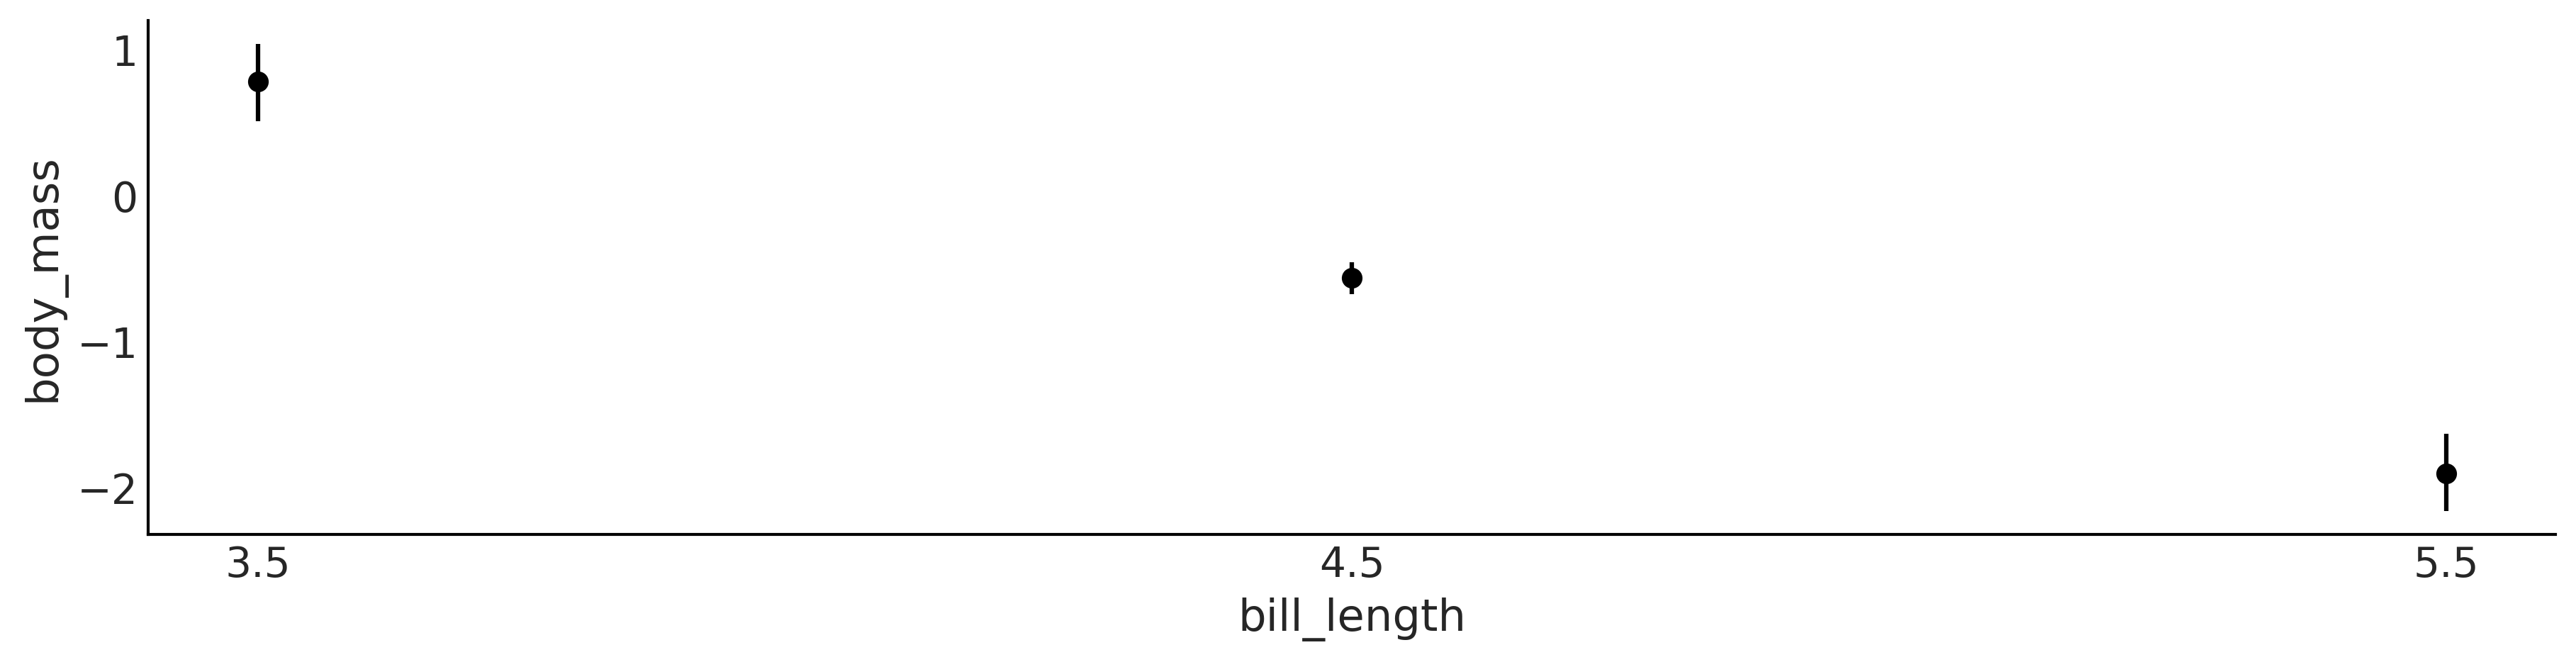

In [34]:
bmb.interpret.plot_comparisons(model_int, idata_int,
                               contrast={"bill_depth":[1.4, 1.8]},
                               conditional={"bill_length":[3.5, 4.5, 5.5]},
                               fig_kwargs={"figsize": (12, 3)})
plt.savefig("../fig/interaction_comparisons.png")

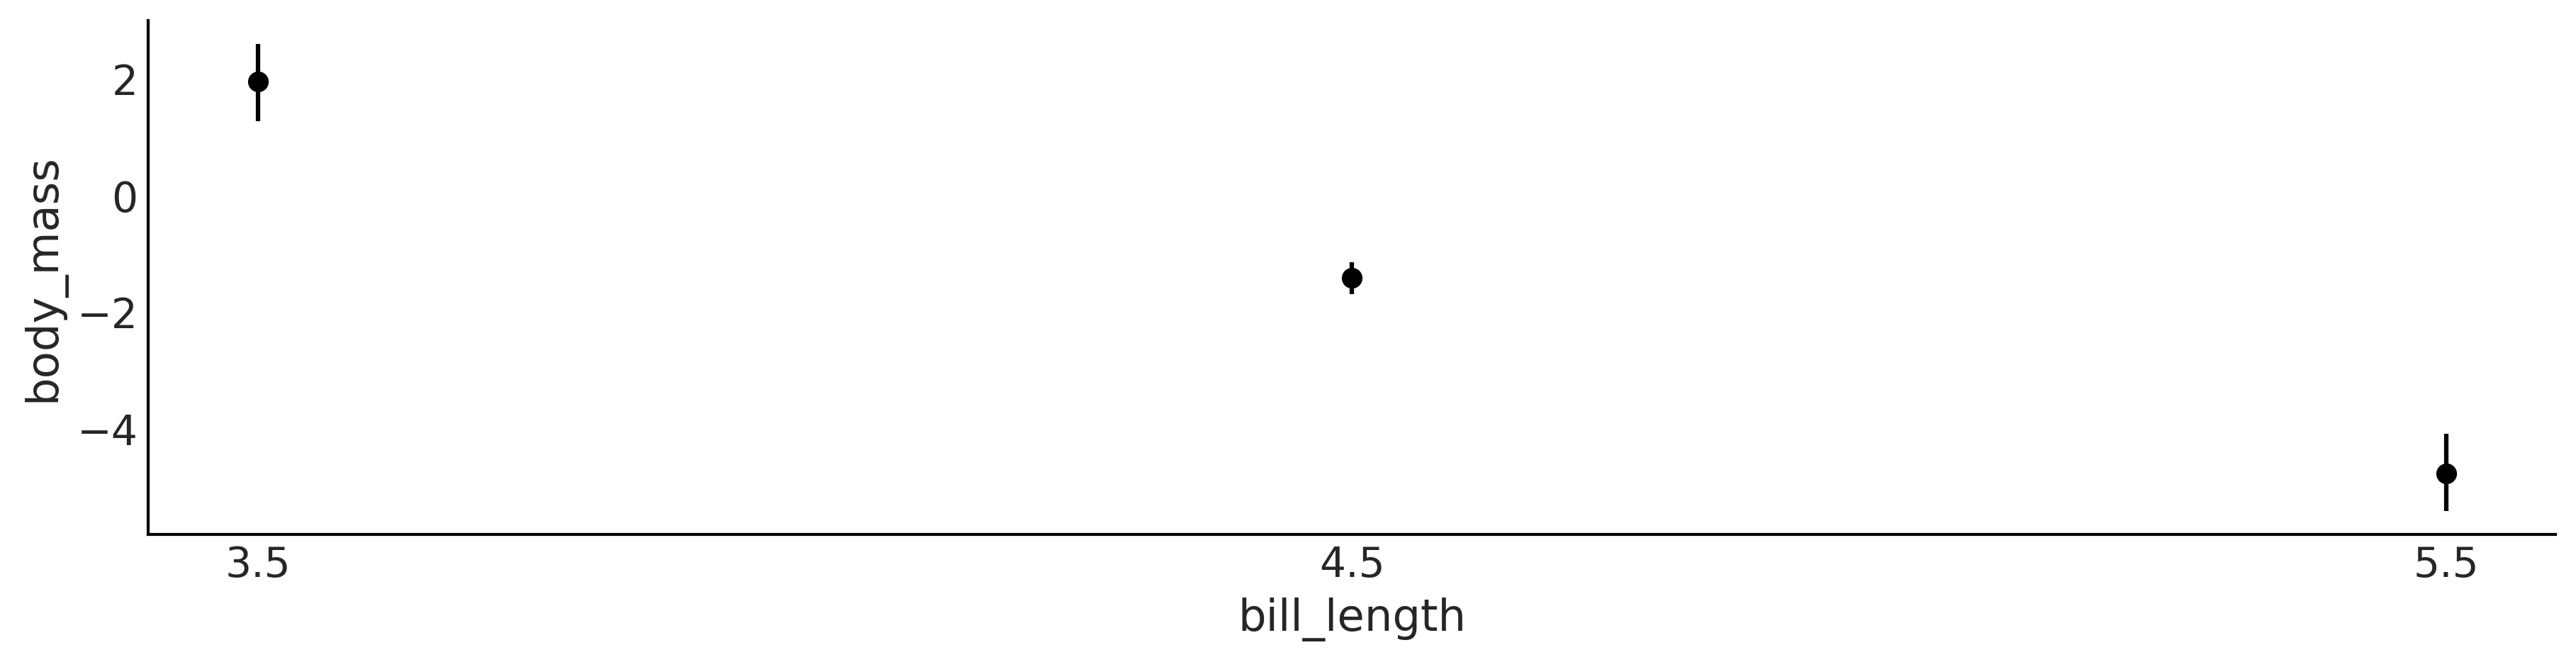

In [35]:
bmb.interpret.plot_slopes(model_int, idata_int,
                          wrt={"bill_depth":1.8},
                          conditional={"bill_length":[3.5, 4.5, 5.5]},
                          fig_kwargs={"figsize": (12, 3)})
plt.savefig("../fig/interaction_slopes.png")

## Variable selection with Kulprit

In [6]:
import kulprit as kpt

In [7]:
body = pd.read_csv("data/body_fat.csv")

In [8]:
body.head()

,siri,age,weight,height,abdomen,thigh,wrist
0,12.3,23,70.1,172,85.2,59.0,17.1
1,6.1,22,78.8,184,83.0,58.7,18.2
2,25.3,22,70.0,168,87.9,59.6,16.6
3,10.4,26,84.0,184,86.4,60.1,18.2
4,28.7,24,83.8,181,100.0,63.2,17.7


In [9]:
model = bmb.Model("siri ~ age + weight + height + abdomen + thigh + wrist", data=body)
idata = model.fit(idata_kwargs={'log_likelihood': True}, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [siri_sigma, Intercept, age, weight, height, abdomen, thigh, wrist]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [10]:
ppi = kpt.ProjectionPredictive(model, idata)
ppi.search()
ppi

  0 siri ~ 1
  1 siri ~ abdomen
  2 siri ~ abdomen + weight
  3 siri ~ abdomen + weight + wrist
  4 siri ~ abdomen + weight + wrist + age
  5 siri ~ abdomen + weight + wrist + age + height
  6 siri ~ abdomen + weight + wrist + age + height + thigh

In [11]:
submodel = ppi.project(3)
submodel

siri ~ abdomen + weight + wrist

/home/eitel/anaconda3/envs/bayes/lib/python3.11/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


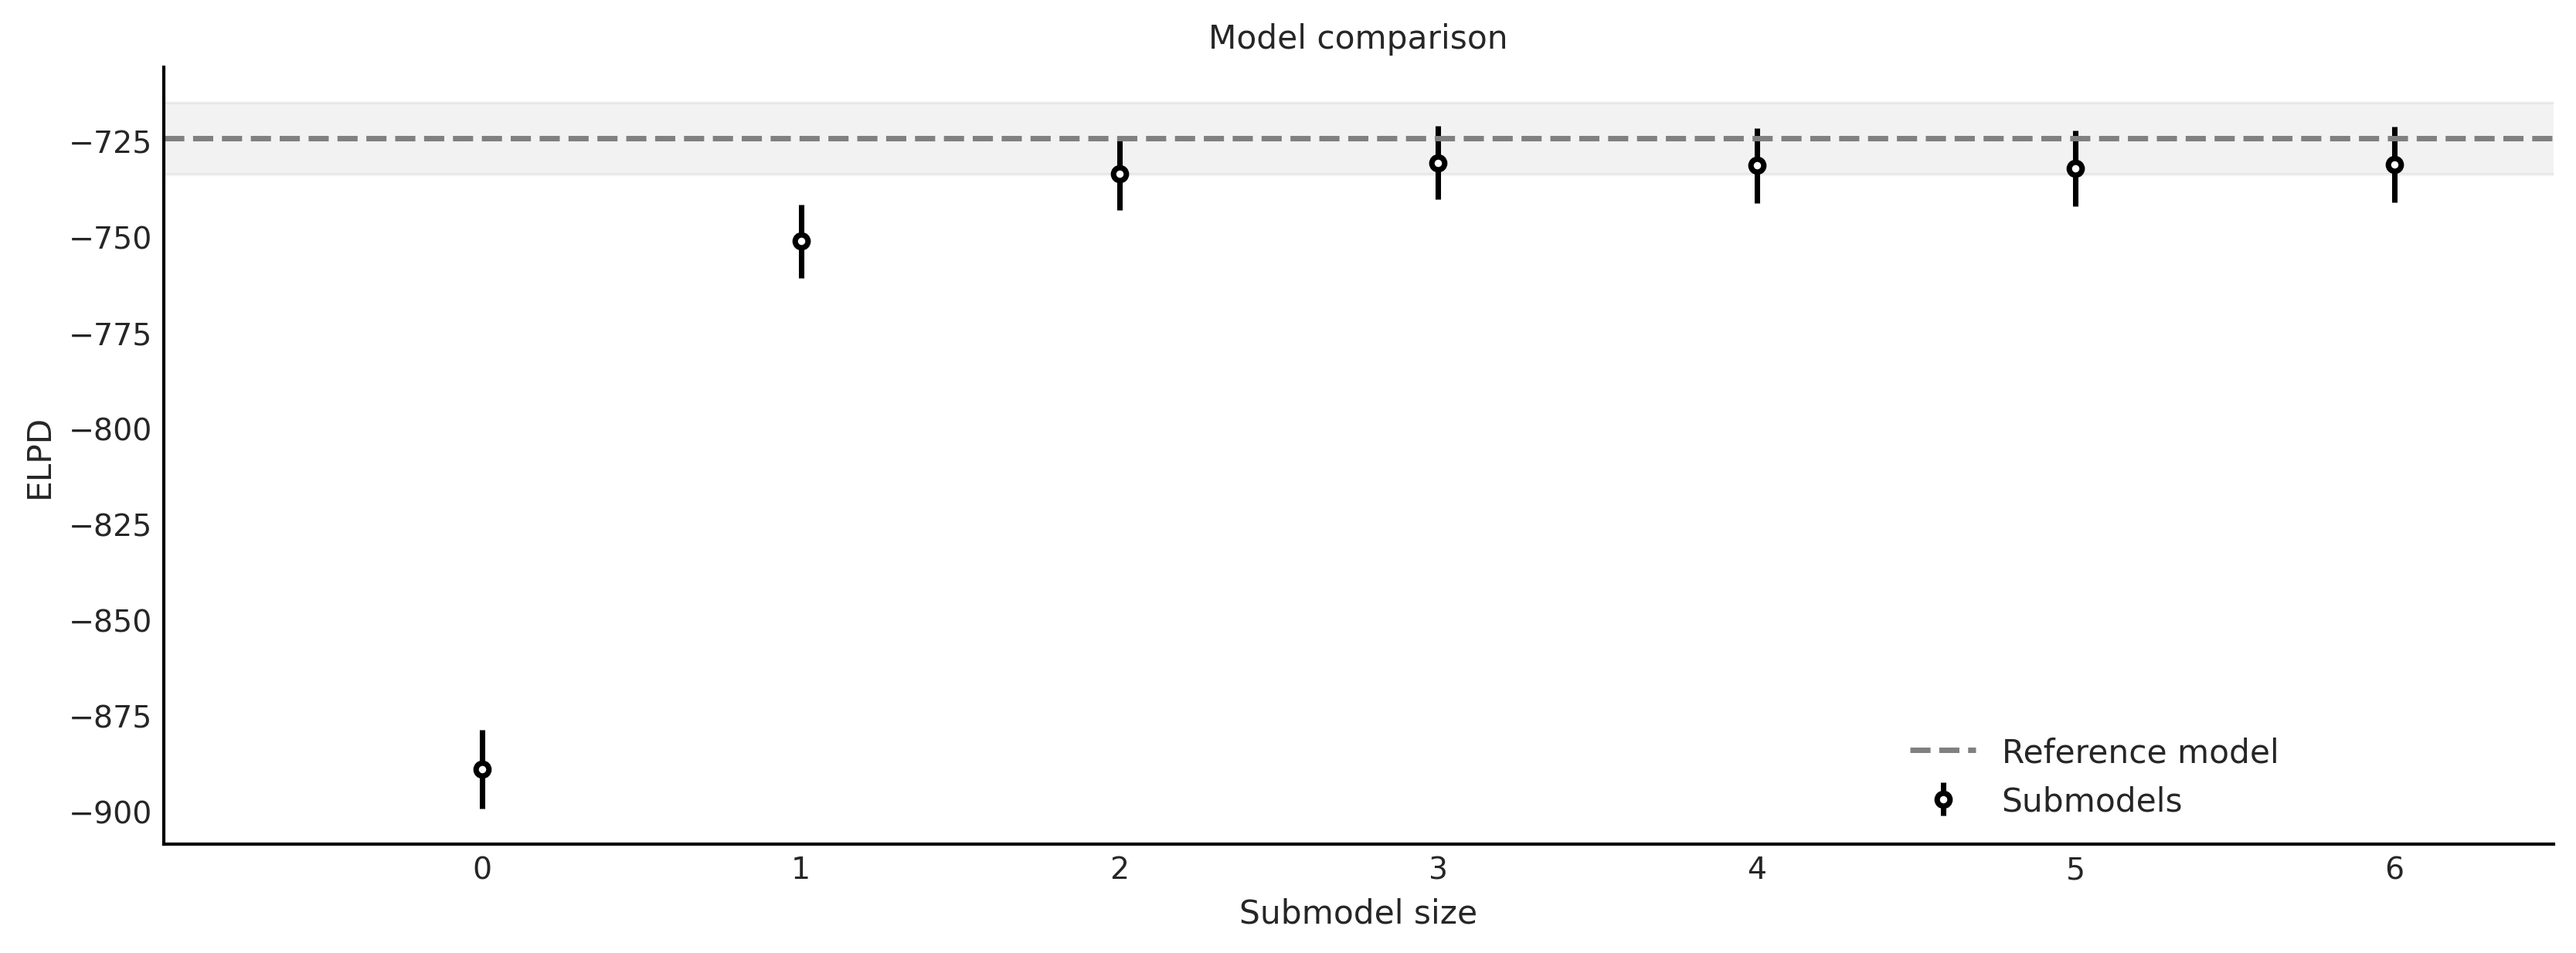

In [12]:
cmp, ax = ppi.plot_compare(plot=True, figsize=(11, 4));
plt.savefig("../fig/body_compare.png")

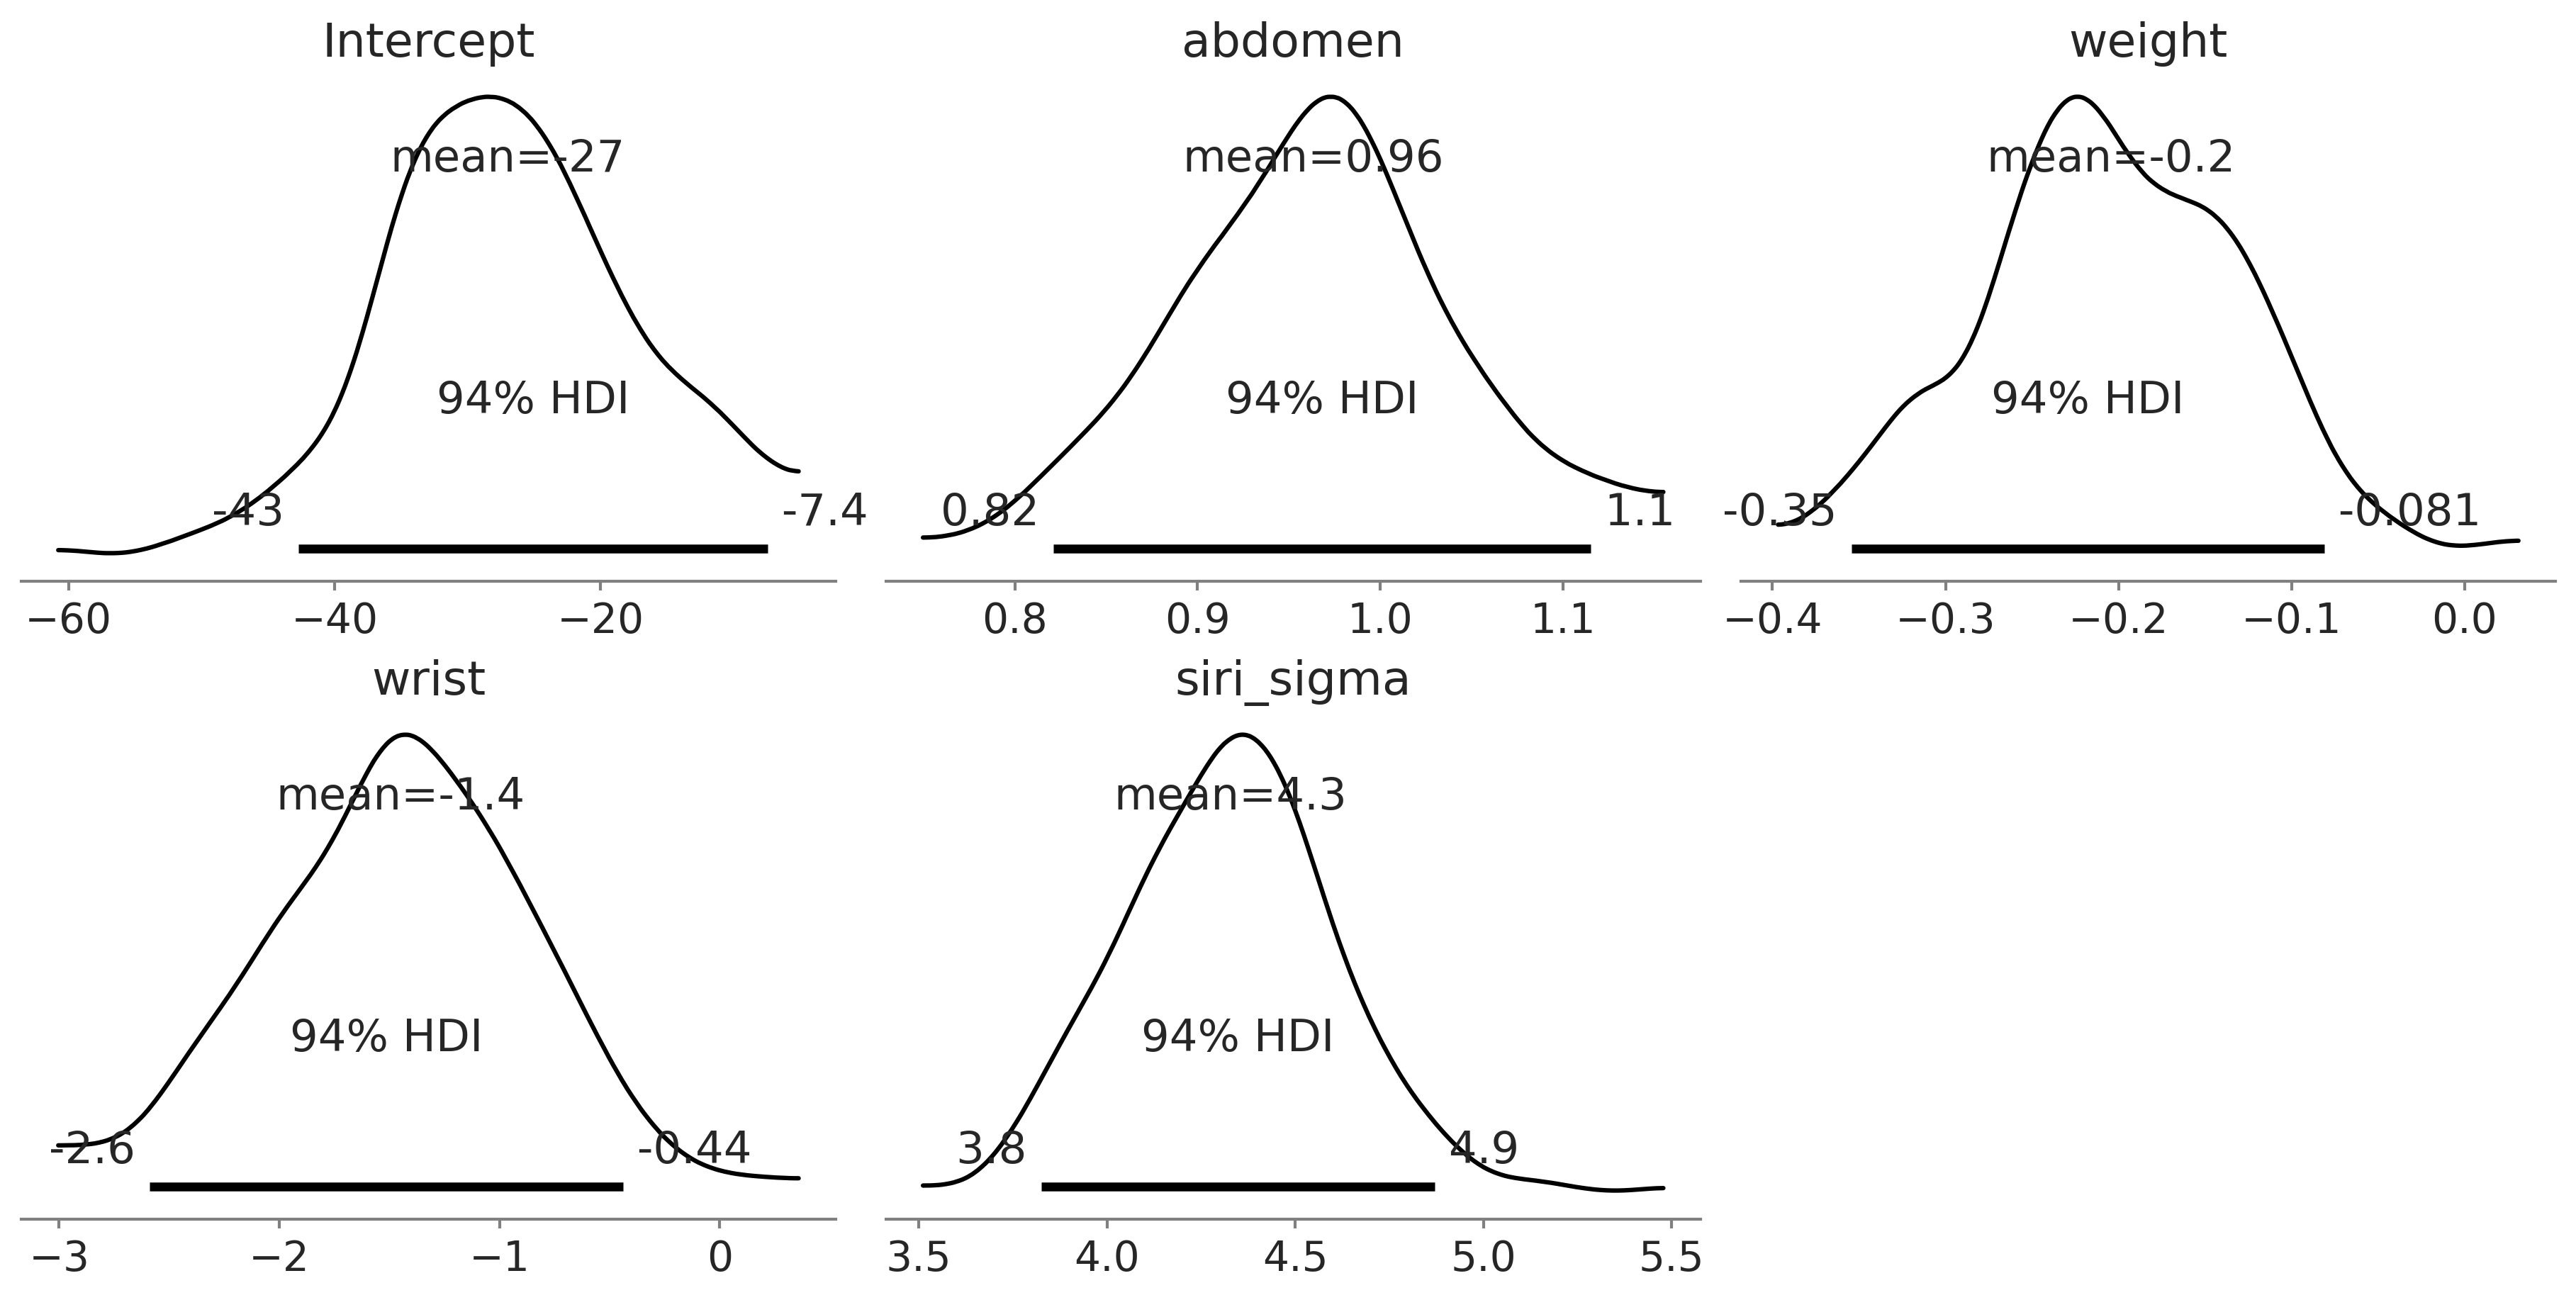

In [13]:
az.plot_posterior(submodel.idata, figsize=(12, 6));
plt.savefig("../fig/body_projected_posterior.png")

In [14]:
"'~' ".join(submodel.term_names)

"abdomen'~' weight'~' wrist"

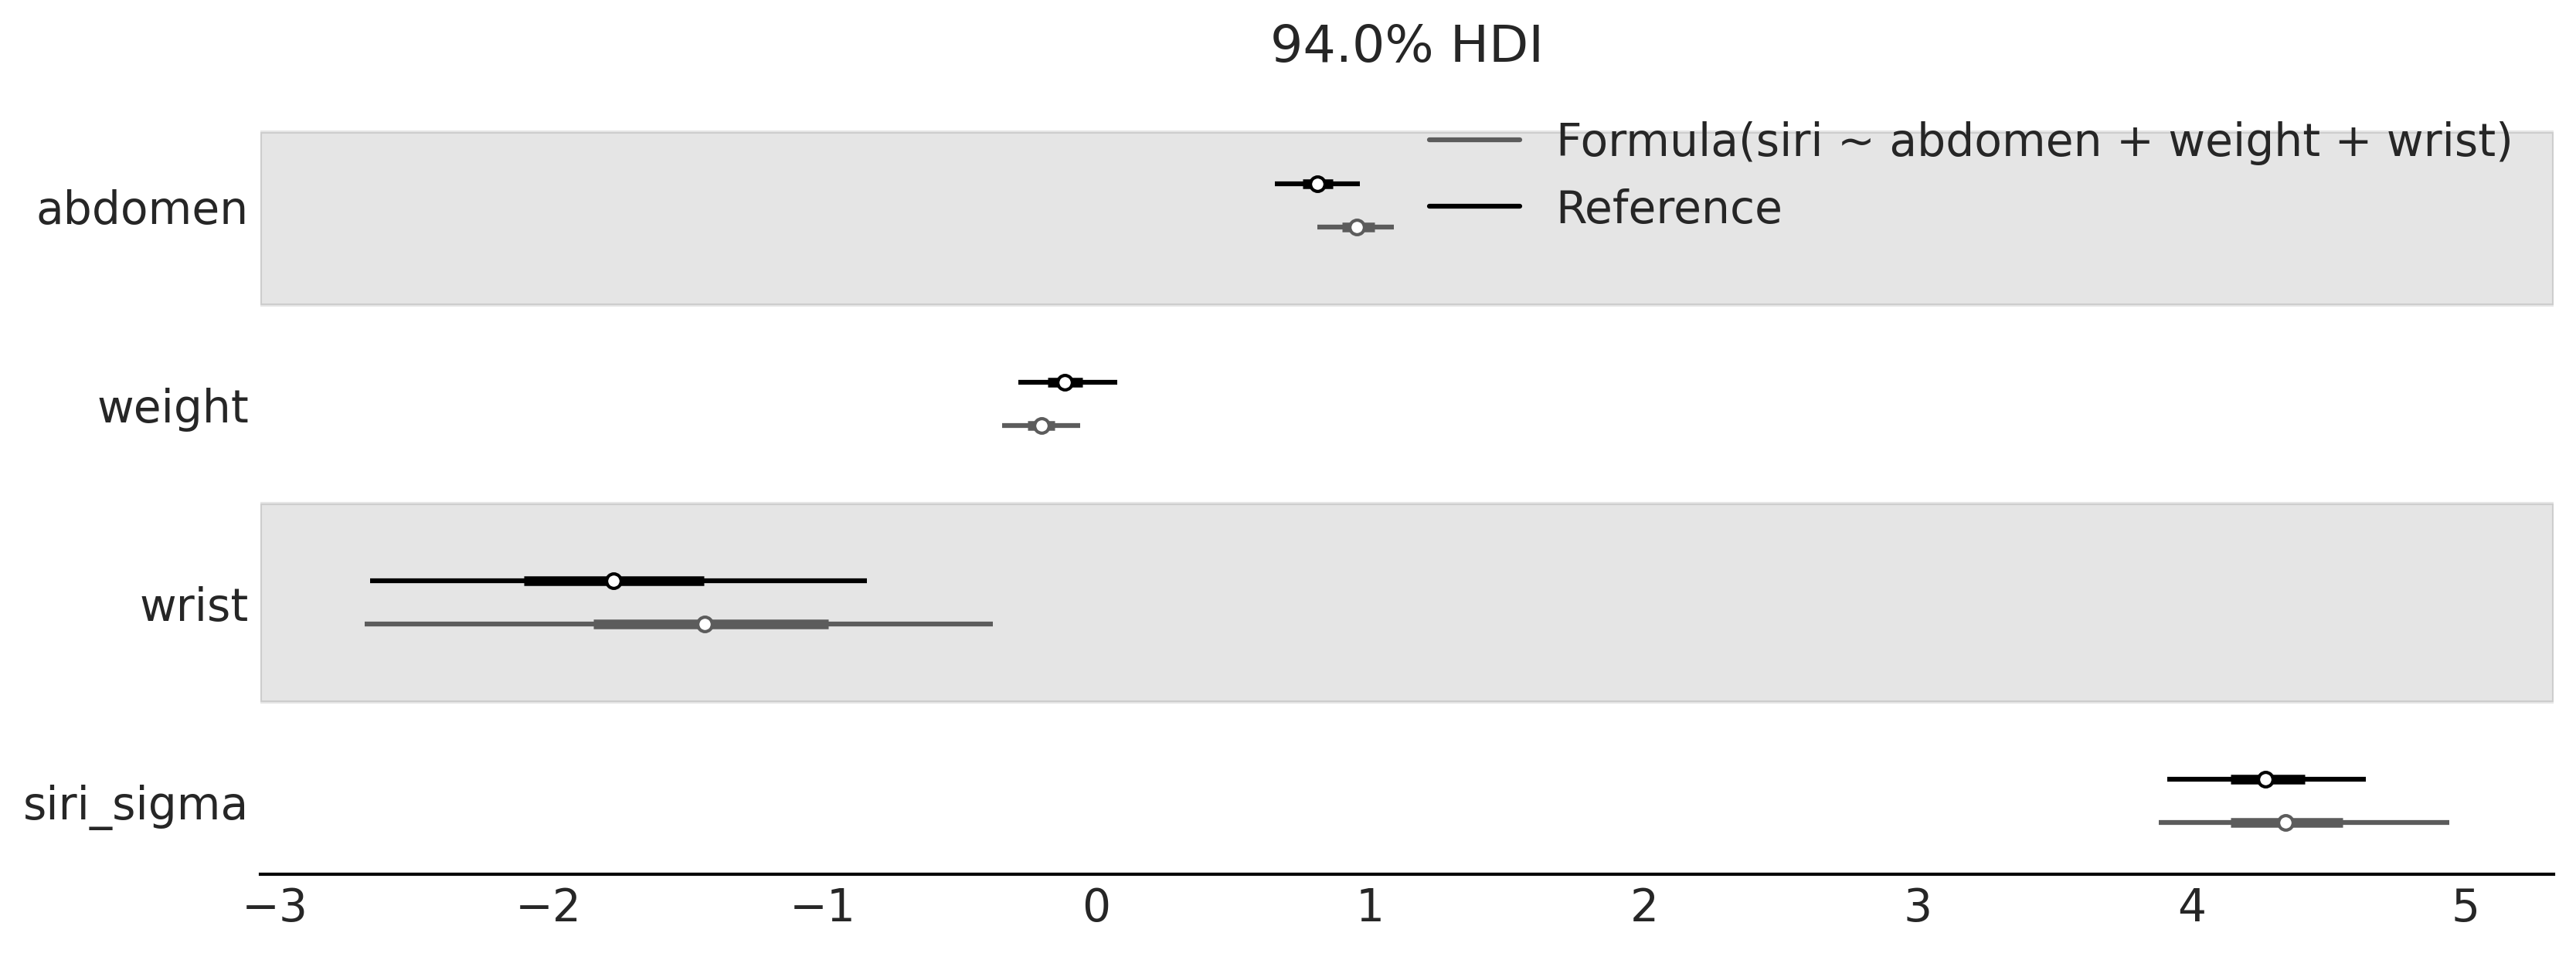

In [45]:
ppi.plot_densities(var_names=["~Intercept", "~age", "~height", "~thigh"],
                   submodels=[3],
                   kind="forest",
                   figsize=(11, 4),
                   plot_kwargs={"colors":["C0", "C2"]});
plt.savefig("../fig/body_true_projected.png")